In [1]:
from os.path import join
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import (
    download_if_needed, json_to_file, file_to_json)
from rastervision.core.evaluation import ensure_json_serializable

import math
from tqdm.auto import tqdm, trange
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

In [2]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize, LogNorm

def draw_windows(ax, windows, errs, vmax=5, cmap='plasma', **kwargs):
    norm = Normalize(0, vmax)
    cmap = plt.get_cmap(cmap)
    cols = cmap(norm(errs))
    for w, c in zip(windows, cols):
        p = Polygon(w.to_points(), ec='k', fc=c, **kwargs)
        ax.add_patch(p)
    ax.autoscale()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.03, label='Absolute error')

In [3]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import RANSACRegressor

def get_chip_pca(embeddings):
    pca = PCA(whiten=True)
    pca.fit(embeddings)
    return pca

def get_chip_fa(embeddings, n_components=None):
    fa = FactorAnalysis(n_components=n_components)
    fa.fit(embeddings)
    return fa

def t_to_feats(t):
    feat_1 = np.sin(t * np.pi * 2)
    feat_2 = np.cos(t * np.pi * 2)
    return np.stack([feat_1, feat_2], axis=1)

def get_chip_regressor(t_doy, Y):
    lr = RANSACRegressor()
    t = np.clip(t_doy / 365, 0, 1)
    X = t_to_feats(t)
    lr.fit(X, Y)
    return lr

def get_chip_err(reg, t_doy, Y):
    t = np.clip(t_doy / 365, 0, 1)
    X = t_to_feats(t)
    error = np.abs(reg.predict(X) - Y)
    return error

In [4]:
from datetime import datetime

def t_strs_to_doy(t_strs):
    doy = [datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs]
    return np.array(doy)

---

## Load embeddings

S3:

In [5]:
embeddings_all = file_to_json('s3://raster-vision-ahassan/sentinel-2-embeddings/42RUR_2017-01-01--2023-07-15.json')

Local:

In [5]:
embeddings_all = file_to_json('42RUR_2017-01-01--2023-07-15.json')

In [6]:
exclude_windows = set([Box(ymin=9000, xmin=10000, ymax=9500, xmax=10500)])

---

## Train on < 2022, predict on 2022

In [7]:
box_to_embeddings_train = {}
box_to_t_strs_train = {}

for t_str, d_t in embeddings_all.items():
    if t_str >= '2022-01-01':
    # if t_str >= '2023-01-01':
        continue
    for w, e_w in zip(d_t['windows_pixel'], d_t['embeddings']):
        w = Box(**w)
        if w in exclude_windows:
            continue
        if w not in box_to_embeddings_train:
            box_to_embeddings_train[w] = []
        if w not in box_to_t_strs_train:
            box_to_t_strs_train[w] = []
        box_to_embeddings_train[w].append(e_w)
        box_to_t_strs_train[w].append(t_str)
    
box_to_embeddings_train = {k: np.array(v) for k, v in box_to_embeddings_train.items()}
box_to_t_strs_train = {k: np.array(v) for k, v in box_to_t_strs_train.items()}

In [8]:
box_to_embeddings_test = {}
box_to_t_strs_test = {}

for t_str, d_t in embeddings_all.items():
    if t_str < '2022-01-01' or t_str > '2022-12-31':
    # if t_str < '2023-01-01' or t_str > '2023-12-31':
        continue
    for w, e_w in zip(d_t['windows_pixel'], d_t['embeddings']):
        w = Box(**w)
        if w not in box_to_embeddings_test:
            box_to_embeddings_test[w] = []
        if w not in box_to_t_strs_test:
            box_to_t_strs_test[w] = []
        box_to_embeddings_test[w].append(e_w)
        box_to_t_strs_test[w].append(t_str)

box_to_embeddings_test = {k: np.array(v) for k, v in box_to_embeddings_test.items()}
box_to_t_strs_test = {k: np.array(v) for k, v in box_to_t_strs_test.items()}

In [9]:
box_to_pca = {b: get_chip_pca(v) for b, v in tqdm(box_to_embeddings_train.items())}

  0%|          | 0/438 [00:00<?, ?it/s]

In [10]:
pc = 0
box_to_reg_pc0 = {
    b: get_chip_regressor(t_strs_to_doy(box_to_t_strs_train[b]), pca.transform(box_to_embeddings_train[b])[:, pc]) 
    for b, pca in tqdm(box_to_pca.items())
}
box_to_pc0_err = {
    b: get_chip_err(reg, t_strs_to_doy(box_to_t_strs_test[b]), box_to_pca[b].transform(box_to_embeddings_test[b])[:, pc]) 
    for b, reg in tqdm(box_to_reg_pc0.items())
}

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

In [11]:
pc = 1

box_to_reg_pc1 = {
    b: get_chip_regressor(t_strs_to_doy(box_to_t_strs_train[b]), pca.transform(box_to_embeddings_train[b])[:, pc]) 
    for b, pca in tqdm(box_to_pca.items())
}

box_to_pc1_err = {
    b: get_chip_err(reg, t_strs_to_doy(box_to_t_strs_test[b]), box_to_pca[b].transform(box_to_embeddings_test[b])[:, pc]) 
    for b, reg in tqdm(box_to_reg_pc1.items())
}

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

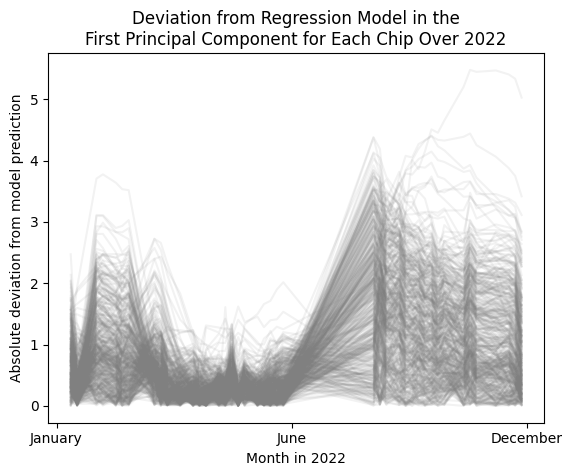

In [15]:
for b, err in box_to_pc0_err.items():
    t_doy = t_strs_to_doy(box_to_t_strs_test[b]) / 365
    plt.plot(t_doy, err, c='gray', alpha=0.1)
plt.xticks([0, 0.5, 1], ['January', 'June', 'December'])
plt.title('Deviation from Regression Model in the\nFirst Principal Component for Each Chip Over 2022')
plt.ylabel('Absolute deviation from model prediction')
plt.xlabel('Month in 2022')
plt.show()

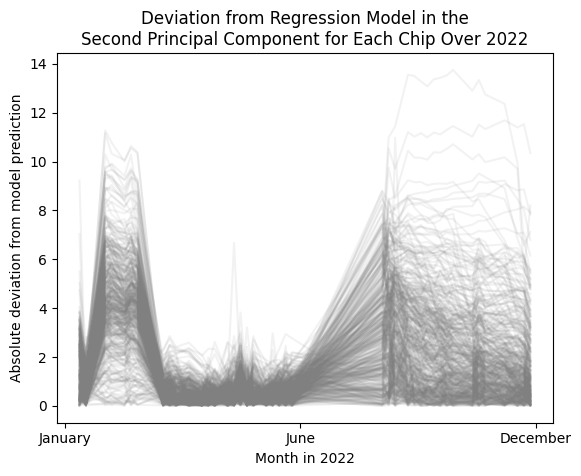

In [16]:
for b, err in box_to_pc1_err.items():
    t_doy = t_strs_to_doy(box_to_t_strs_test[b]) / 365
    plt.plot(t_doy, err, c='gray', alpha=0.1)
plt.xticks([0, 0.5, 1], ['January', 'June', 'December'])
plt.title('Deviation from Regression Model in the\nSecond Principal Component for Each Chip Over 2022')
plt.ylabel('Absolute deviation from model prediction')
plt.xlabel('Month in 2022')
plt.show()

### Intensity of change for each chip for each timestamp

As measured by the absolute difference from the regression fit.

In [37]:
box_to_t_str_to_pc0_err = {b: {t_str: e for t_str, e in zip(box_to_t_strs_test[b], v)} for b, v in box_to_pc0_err.items()}

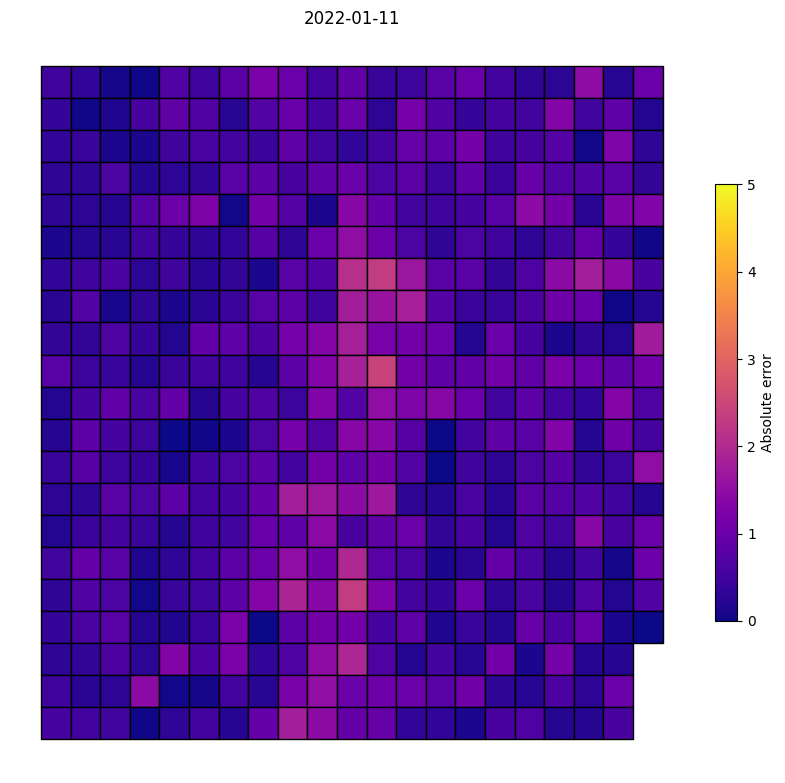

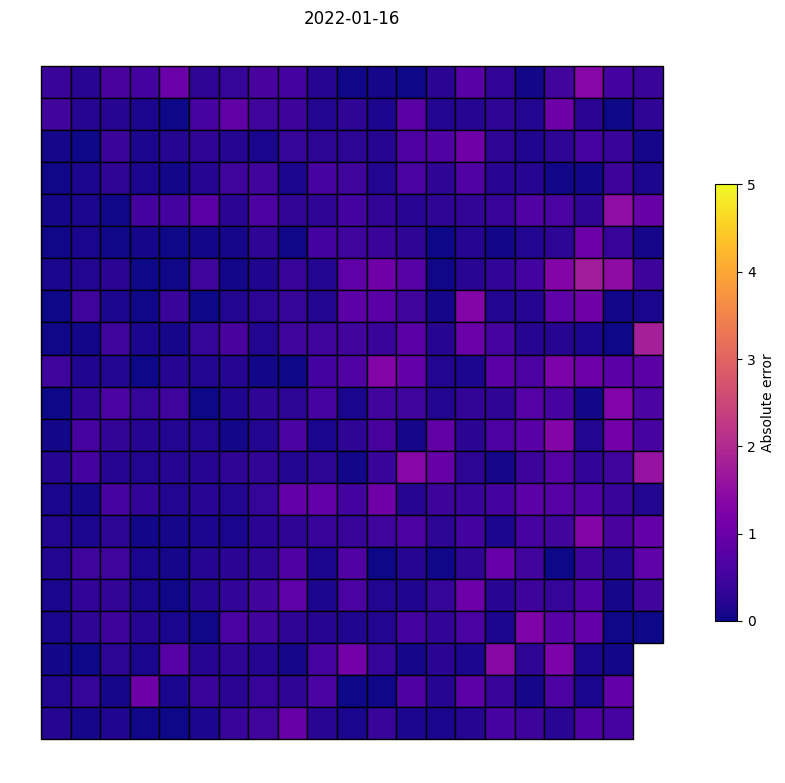

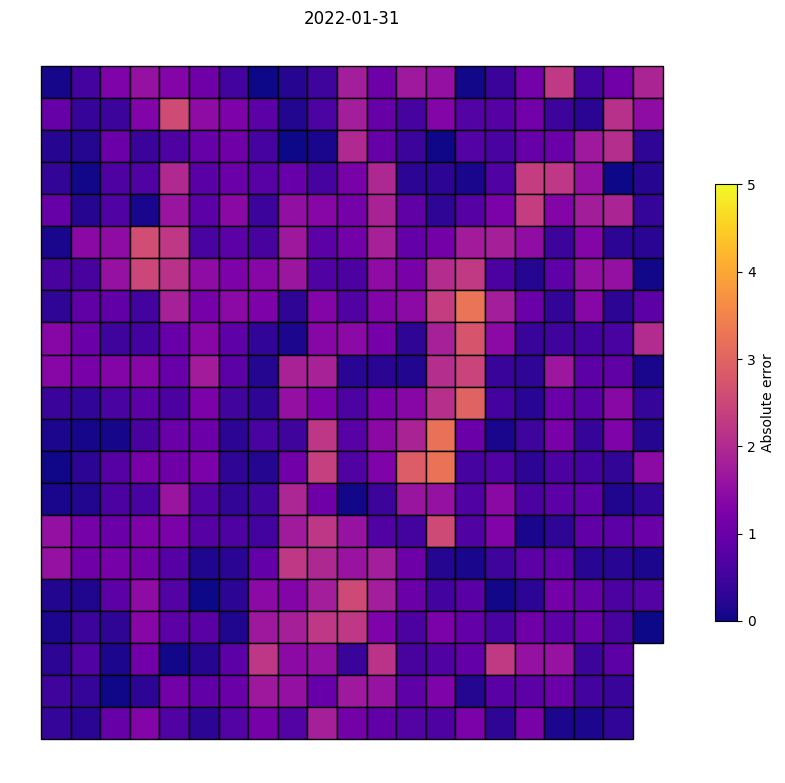

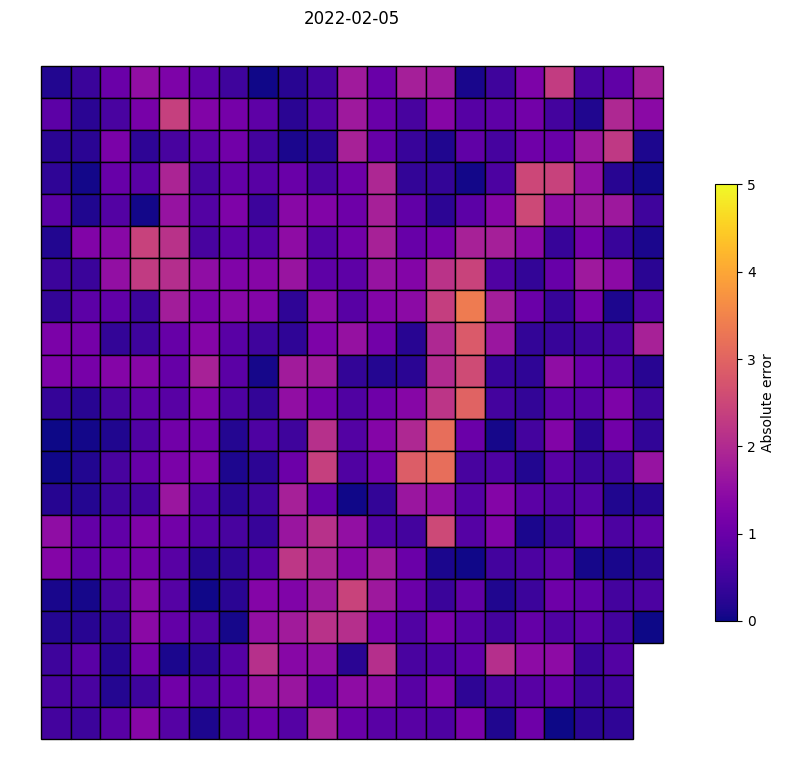

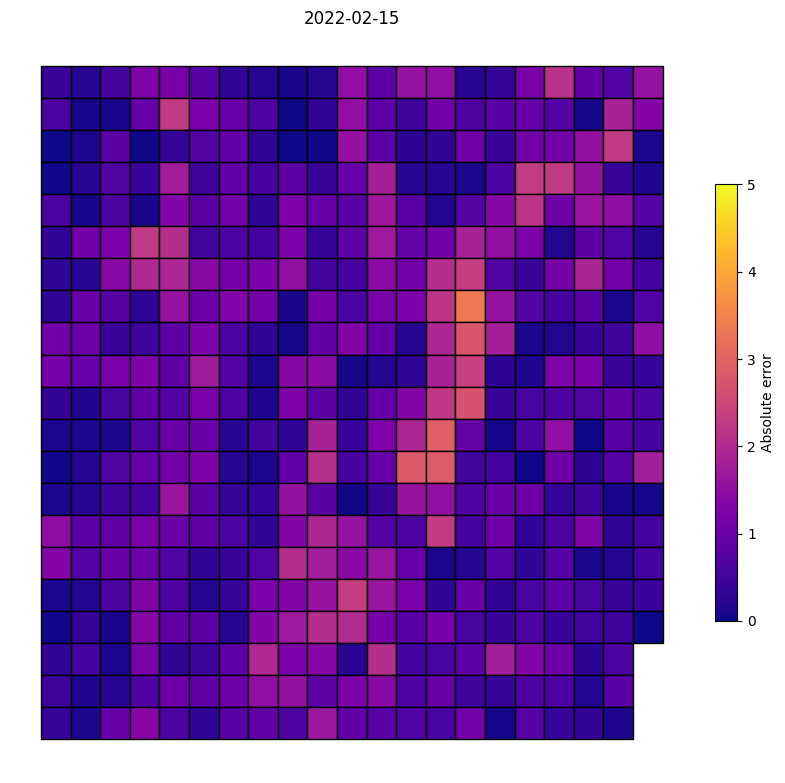

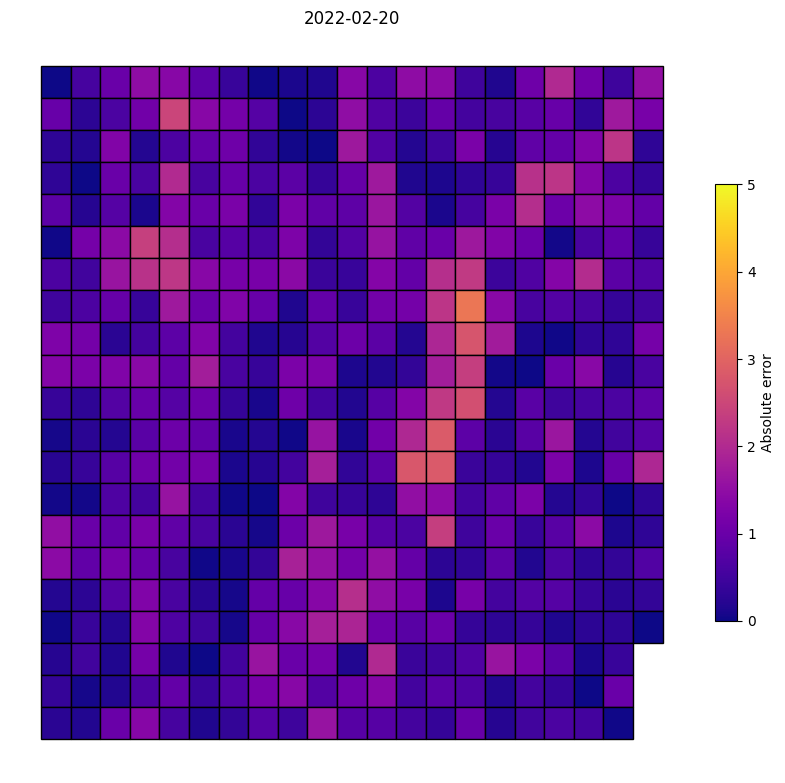

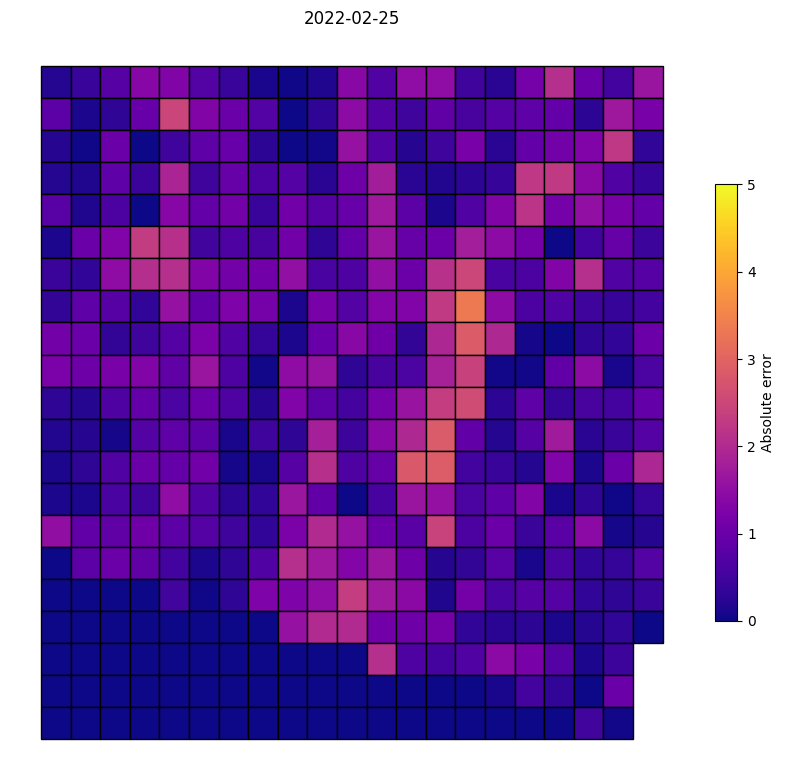

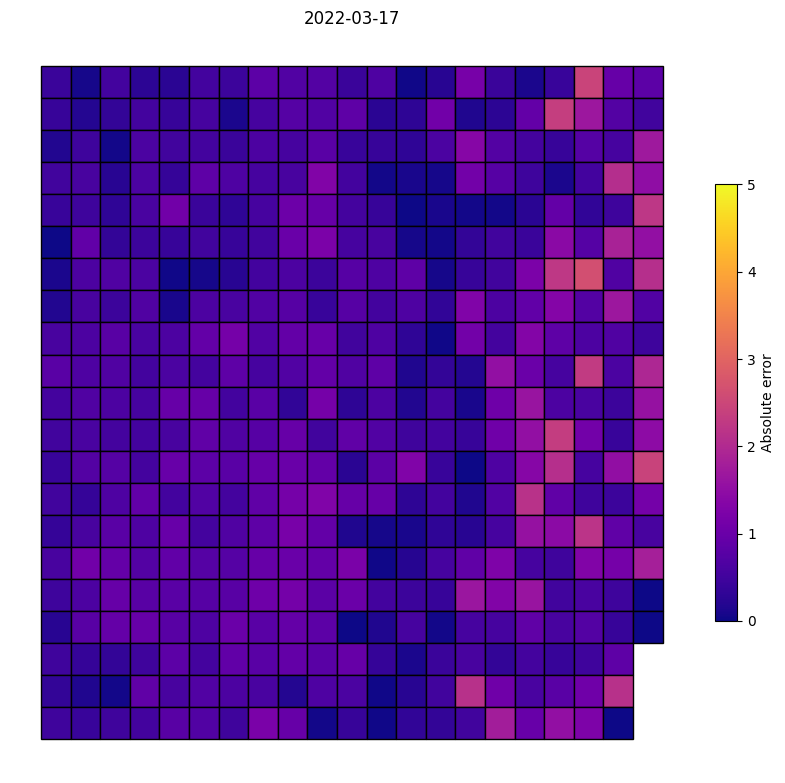

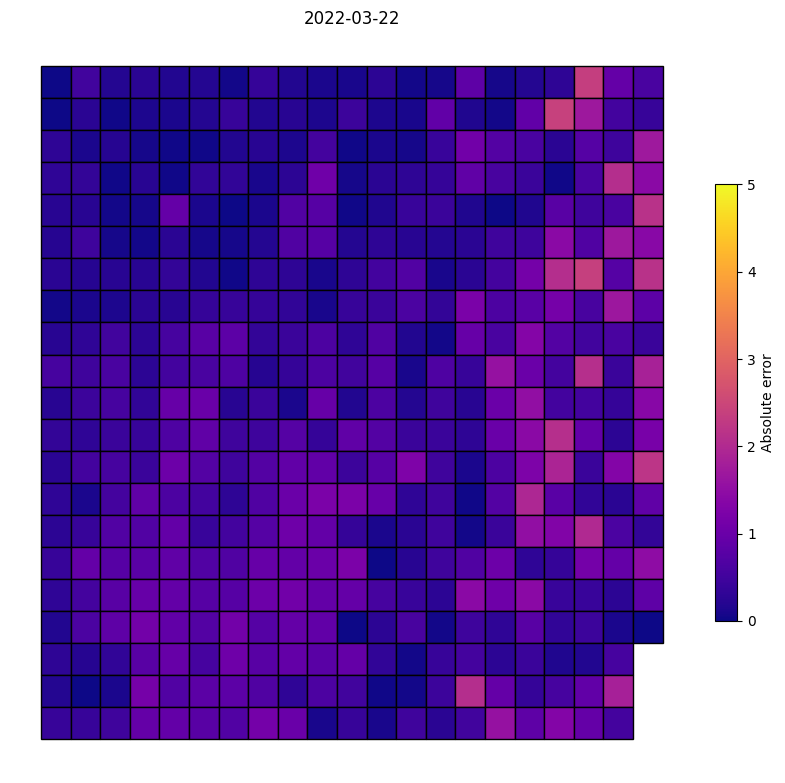

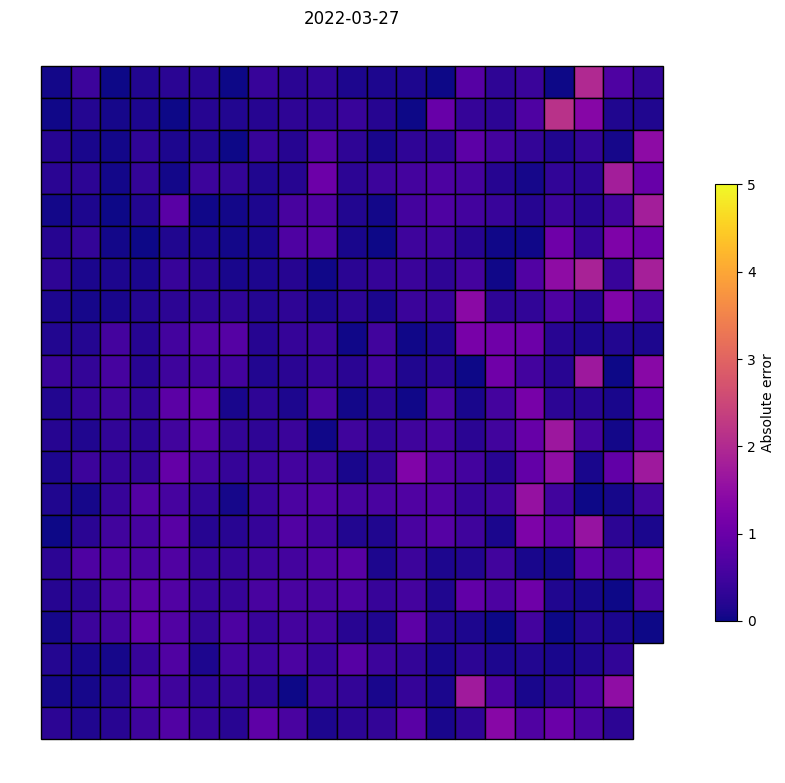

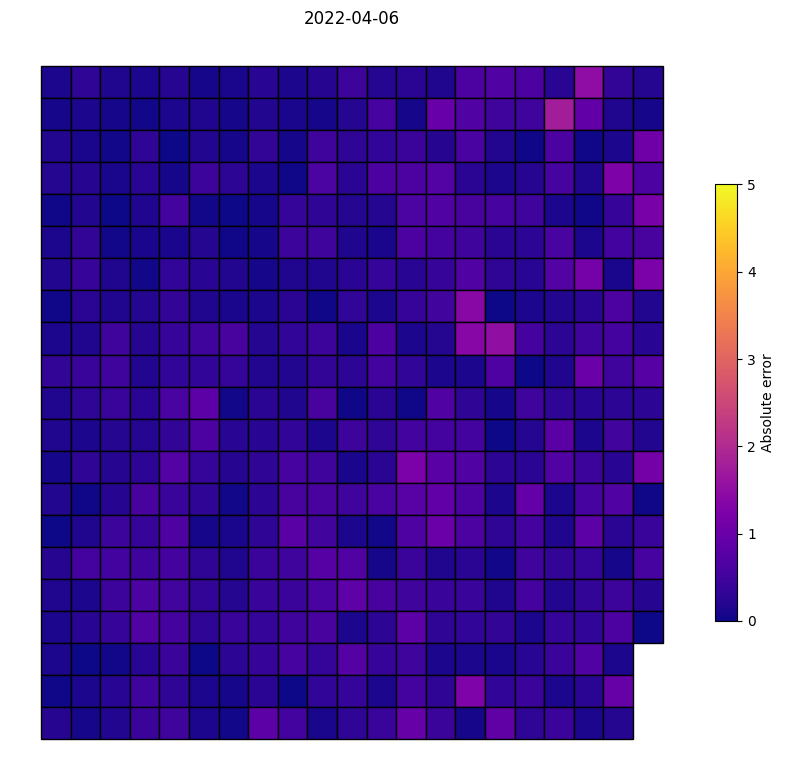

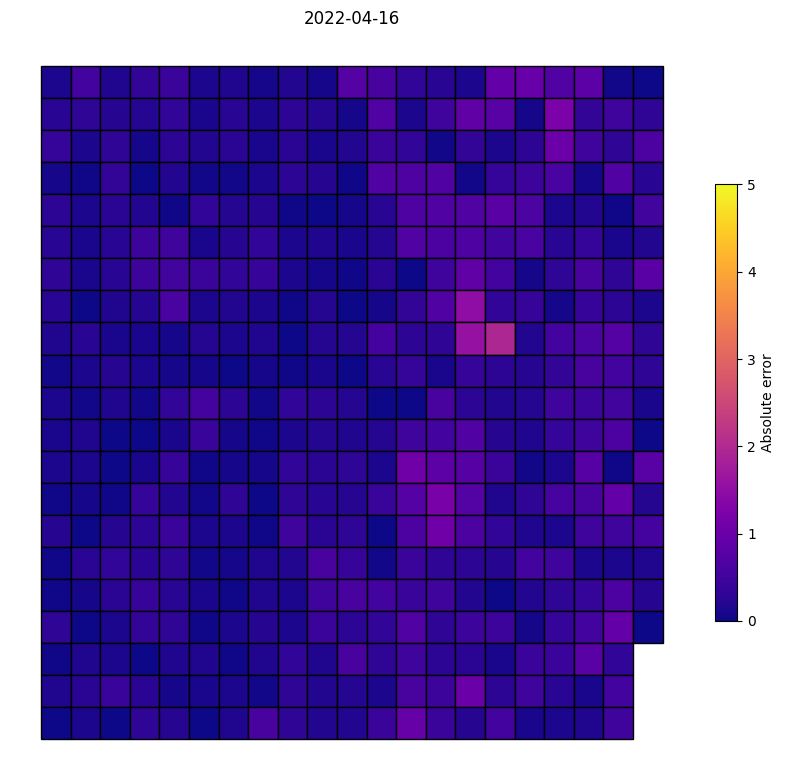

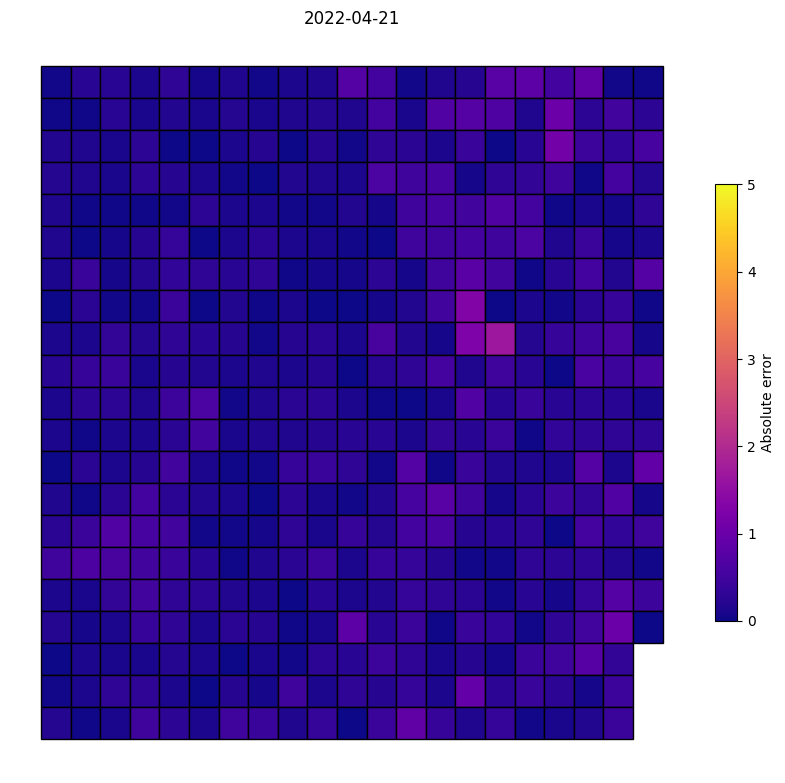

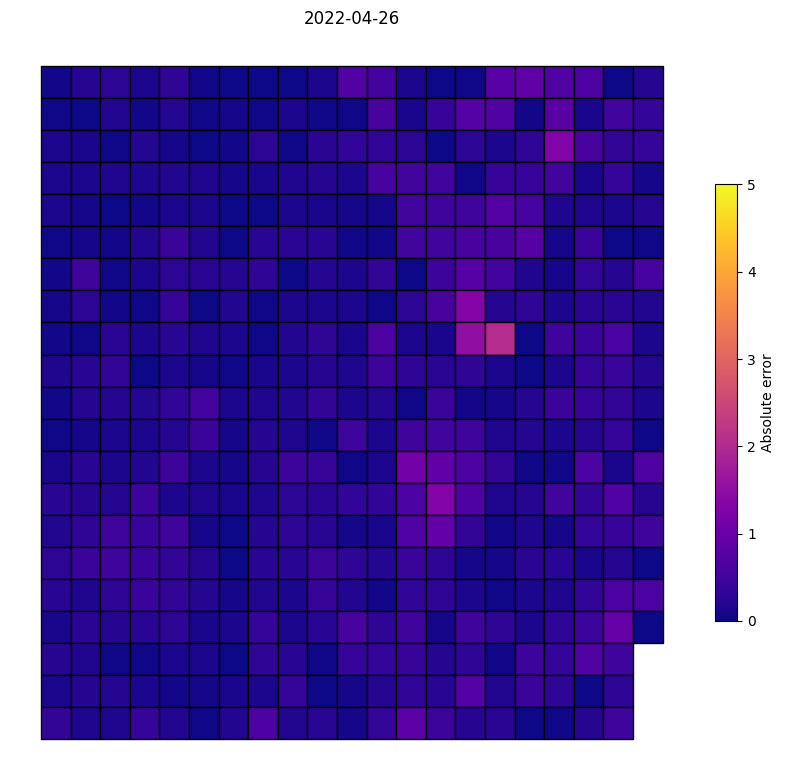

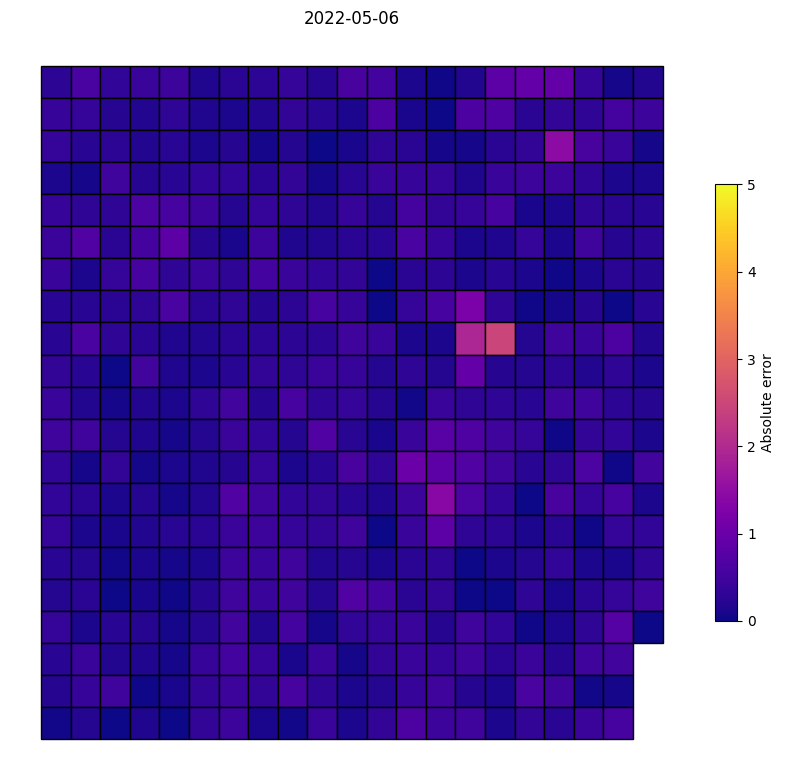

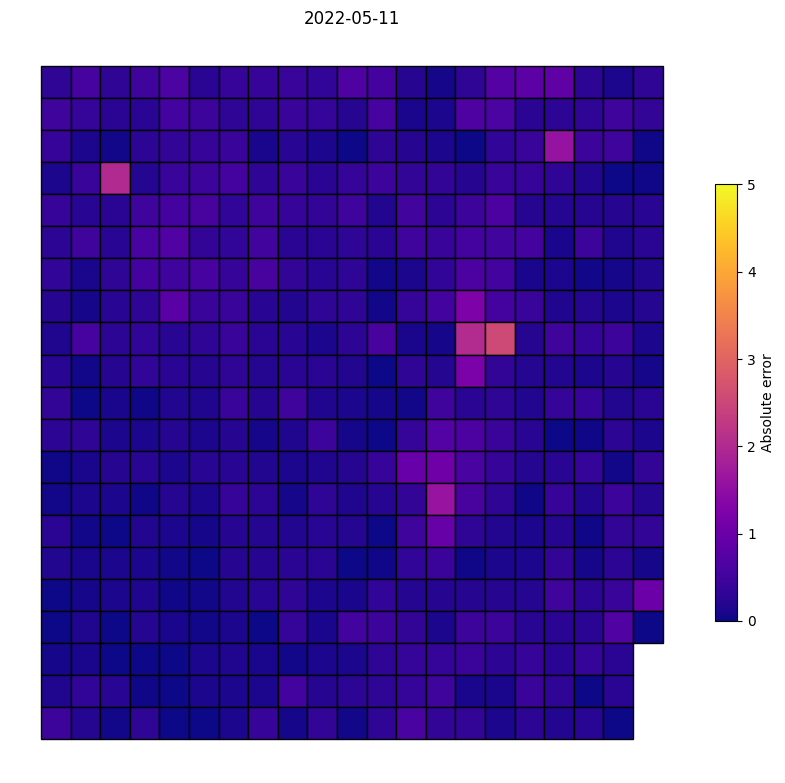

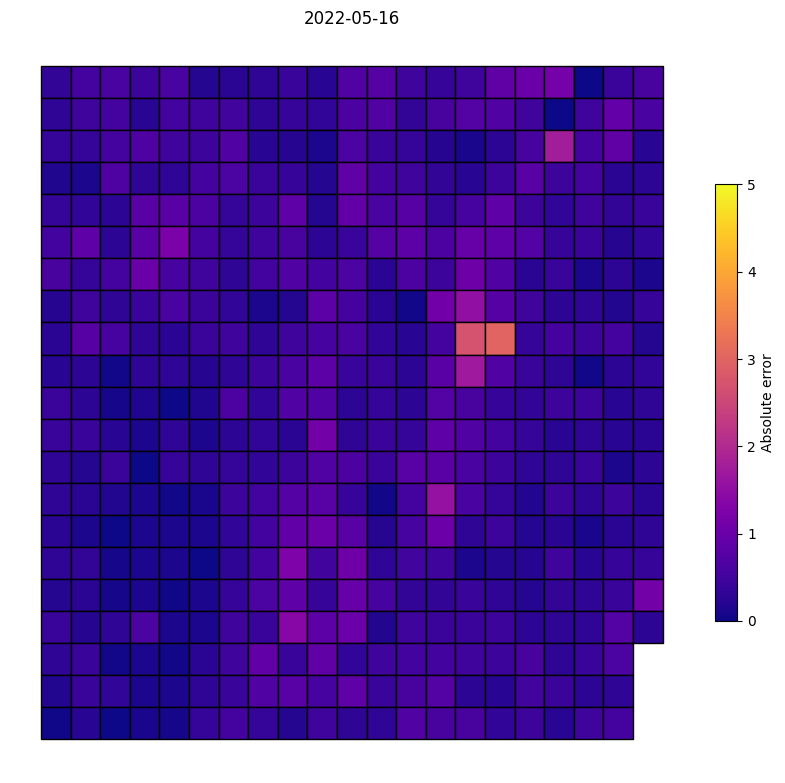

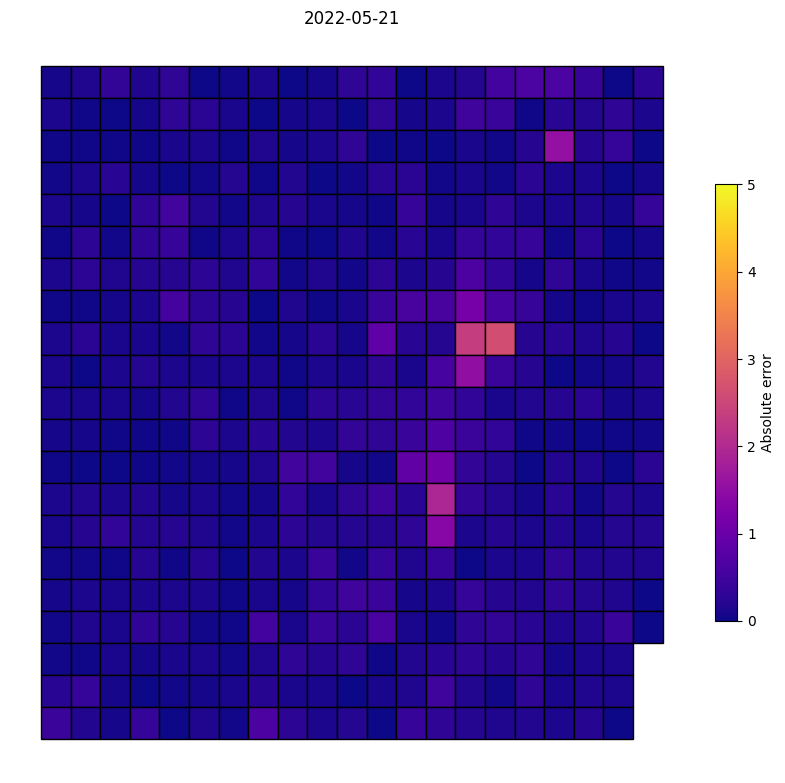

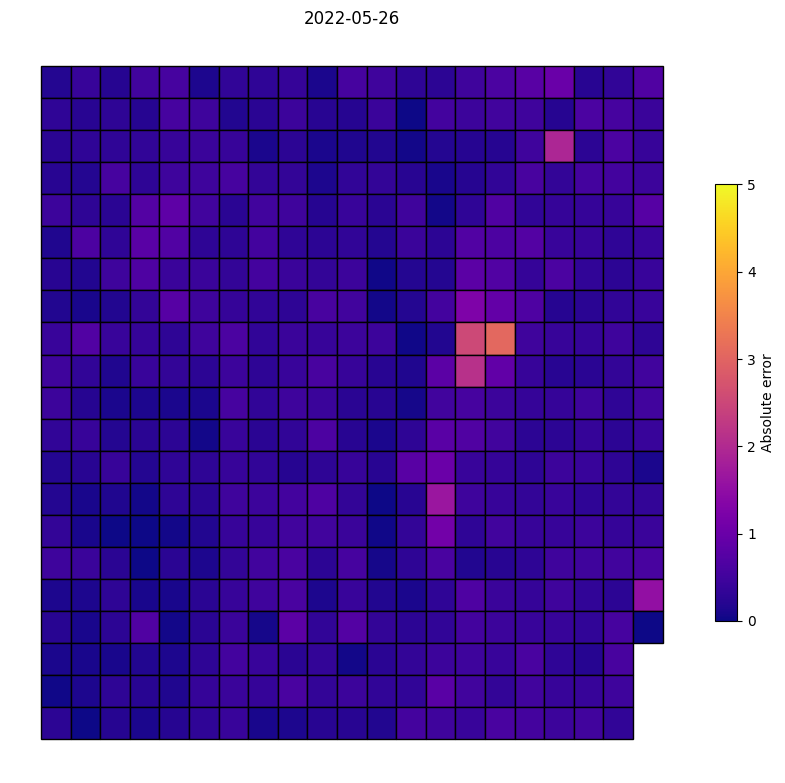

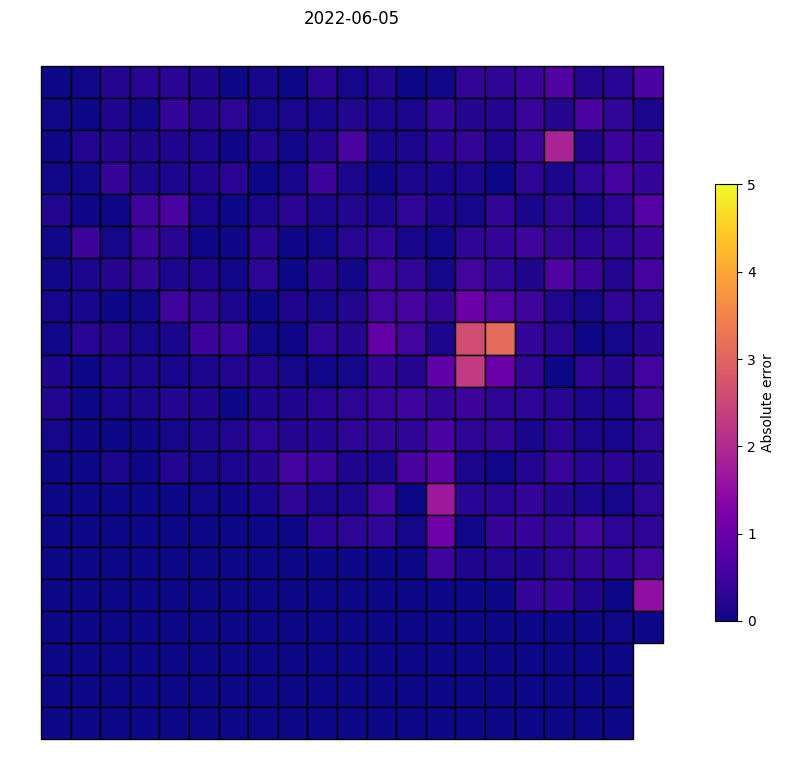

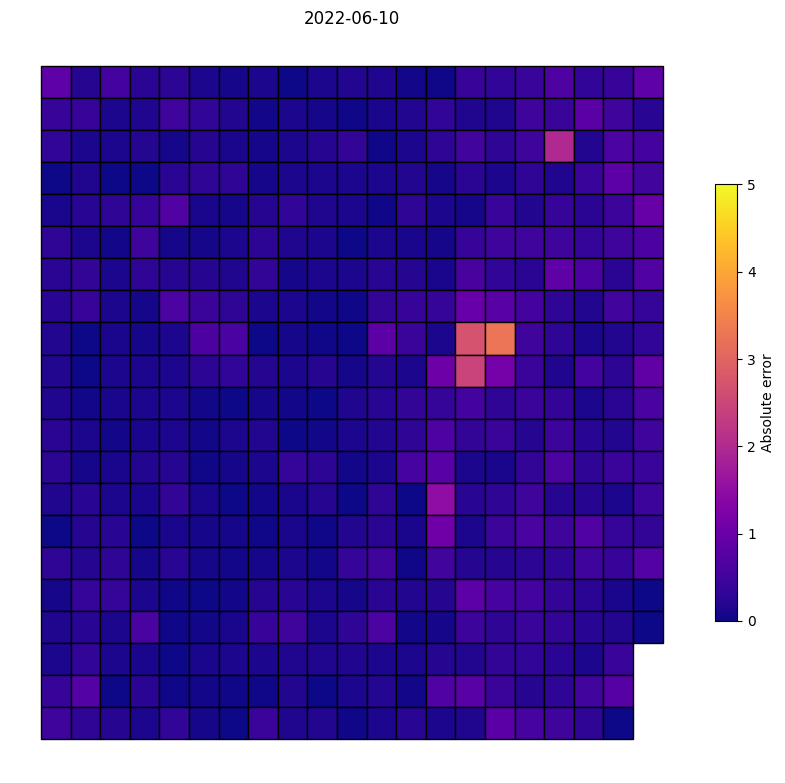

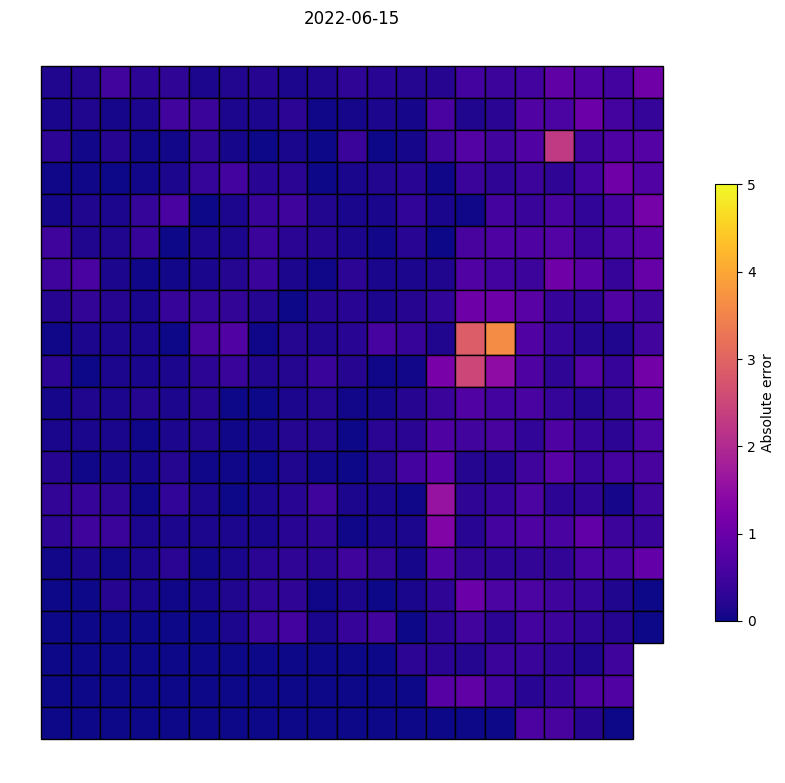

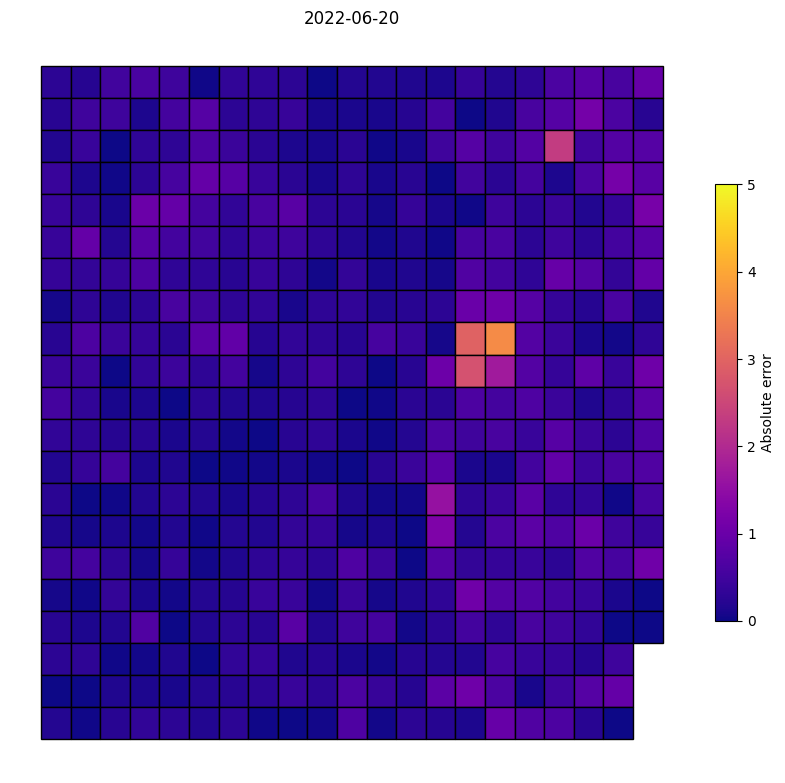

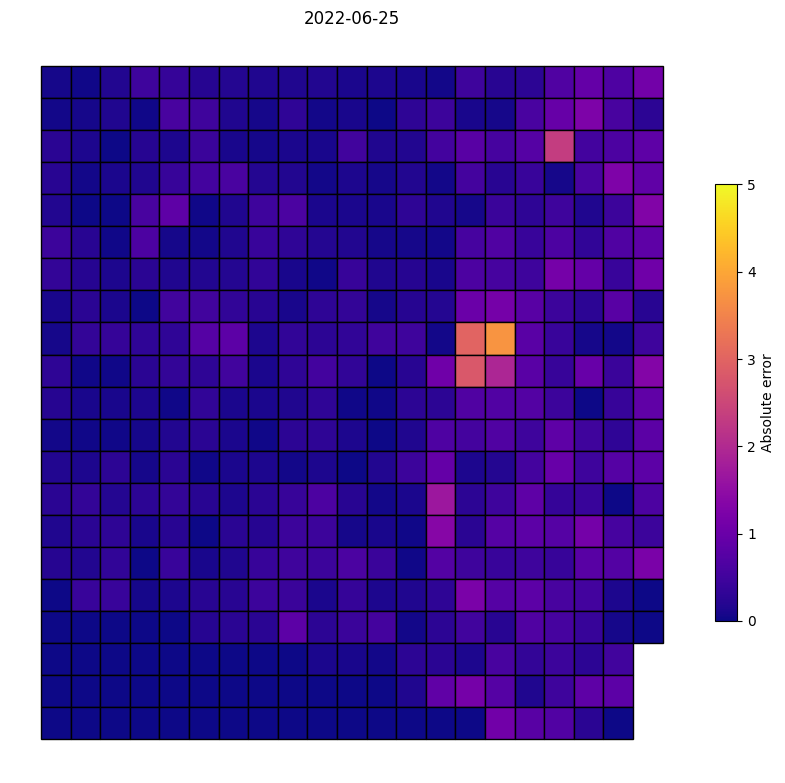

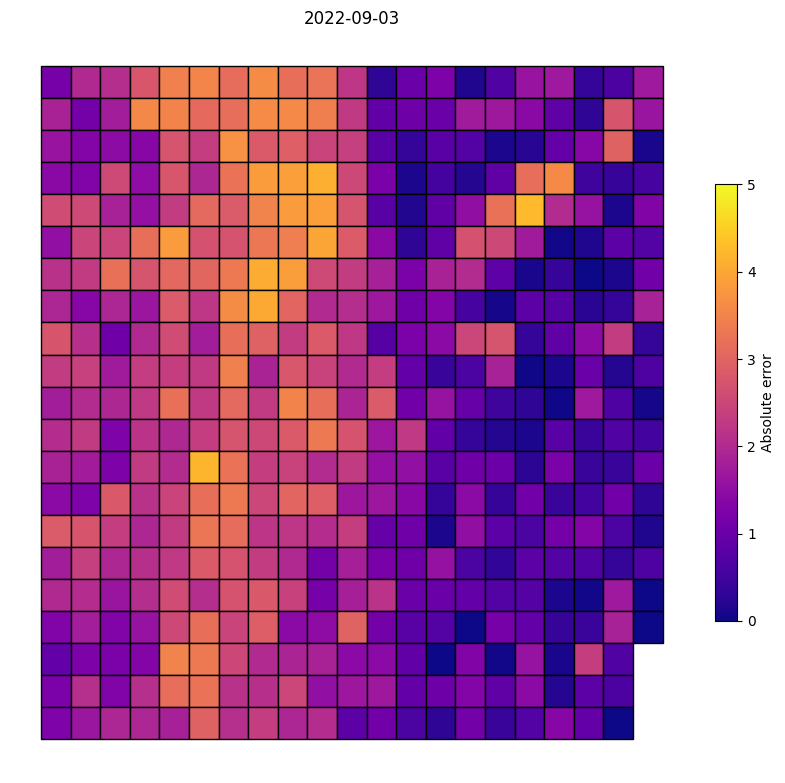

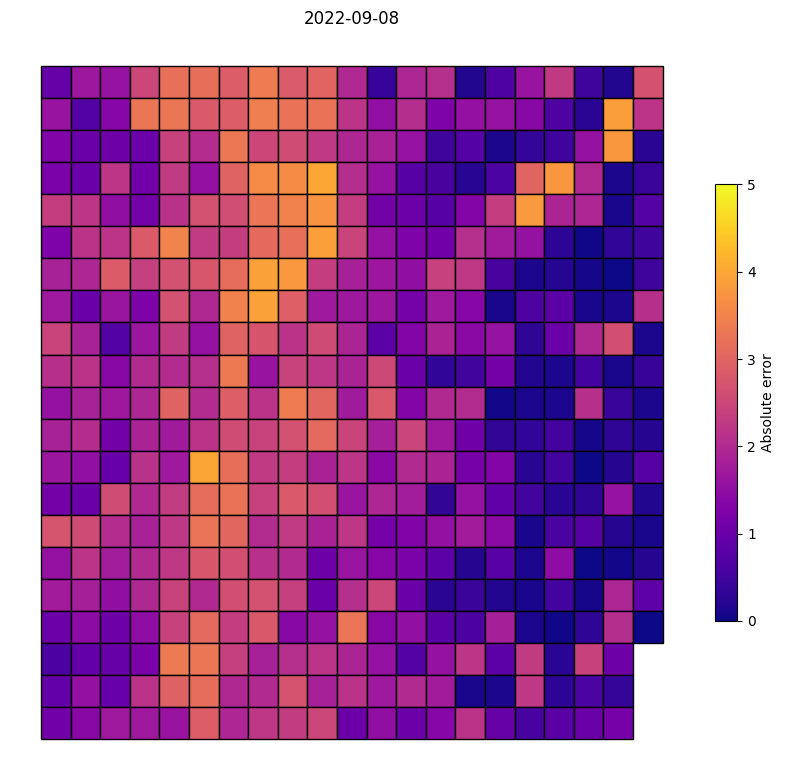

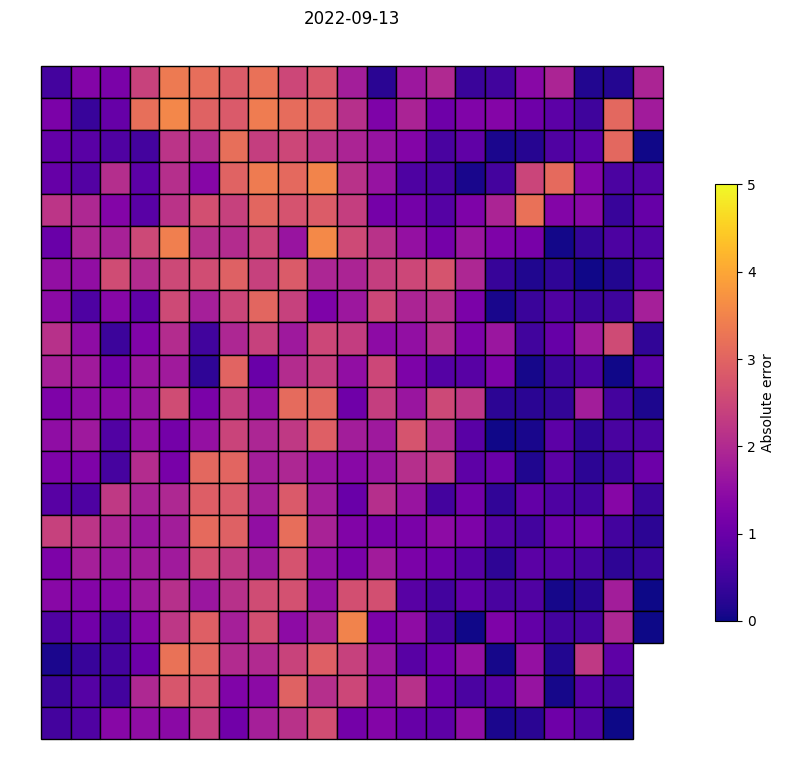

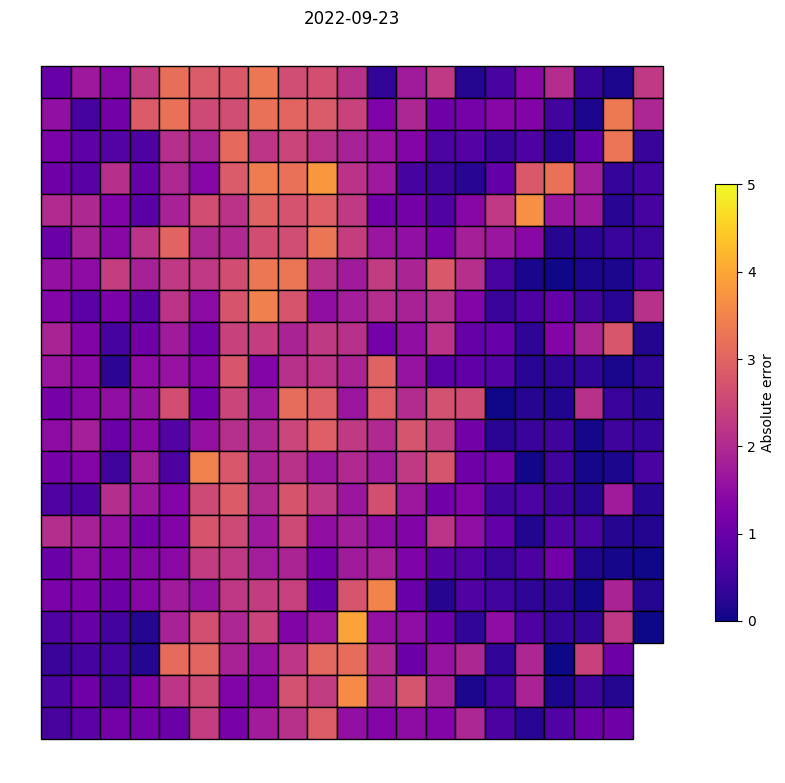

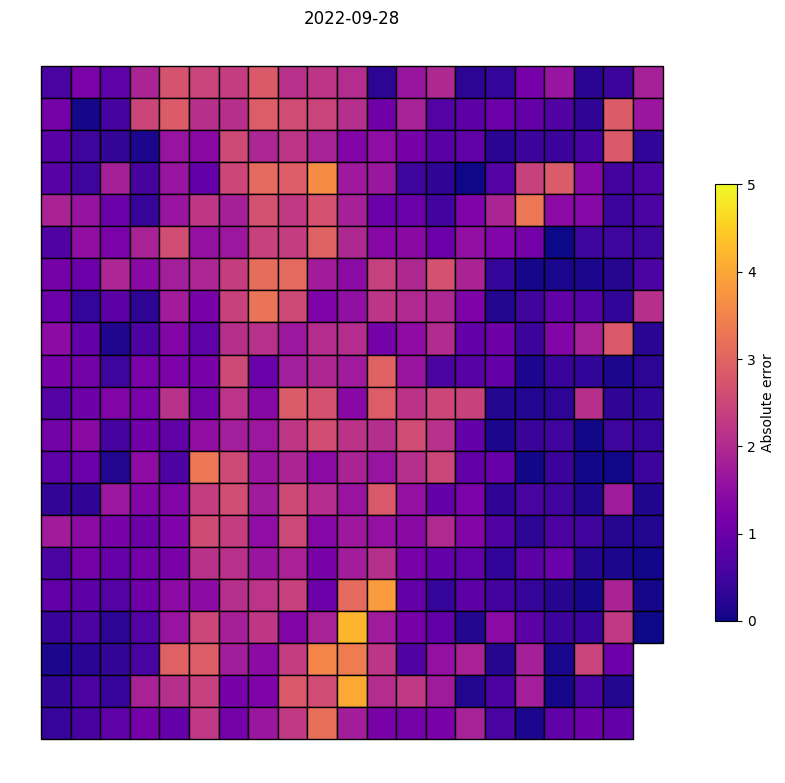

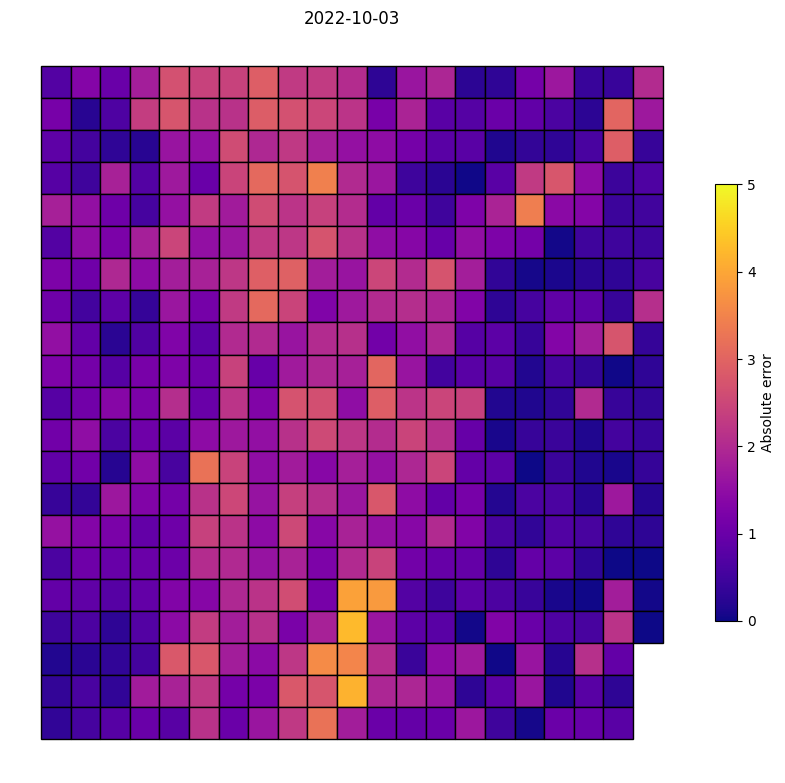

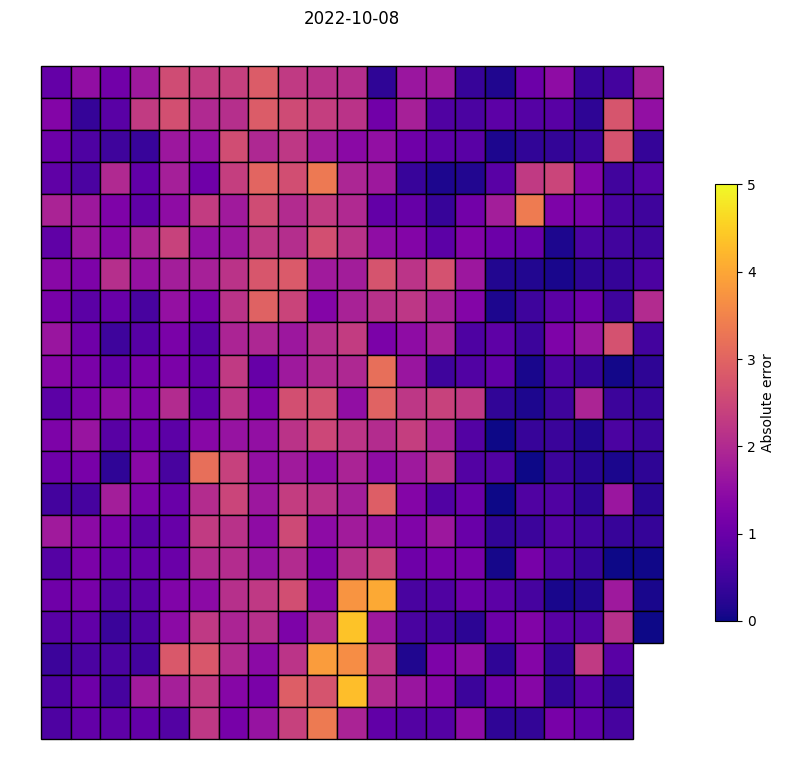

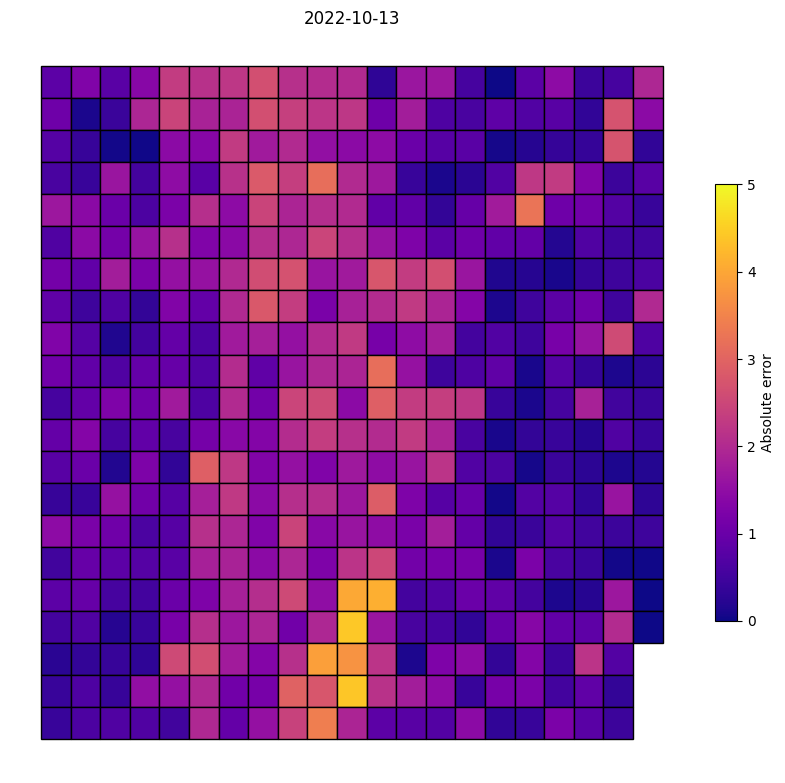

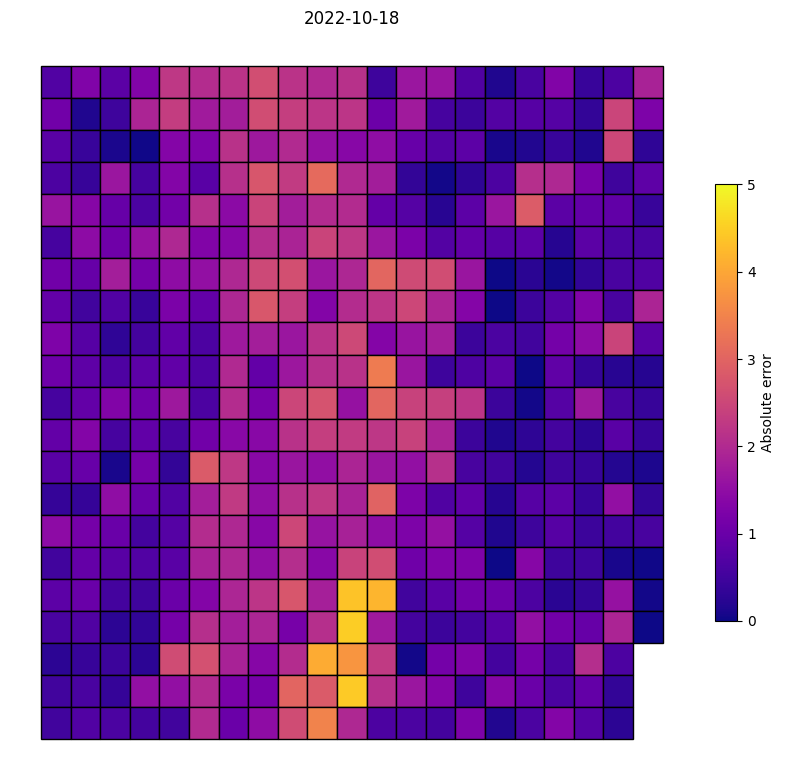

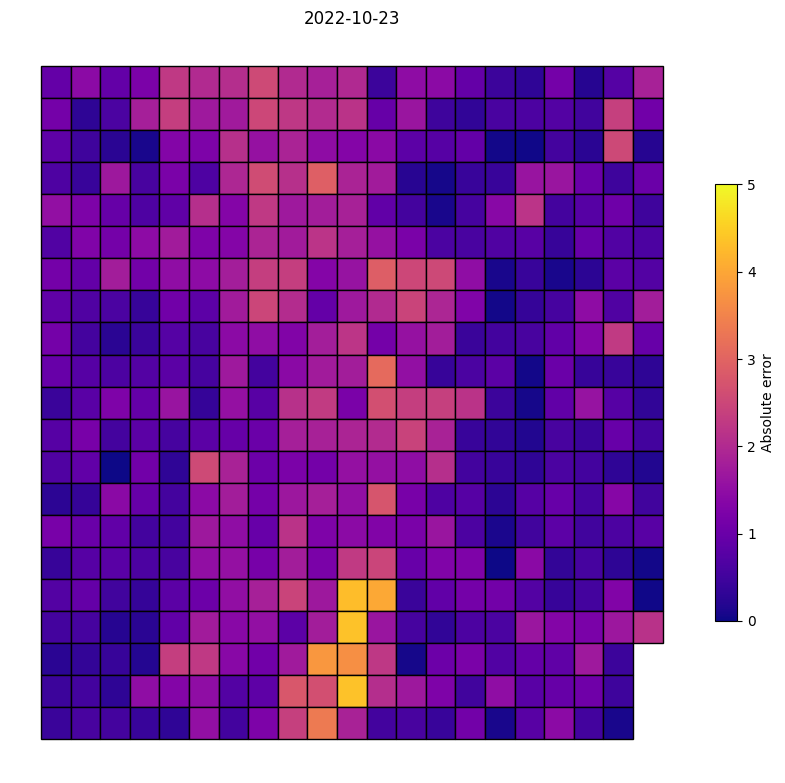

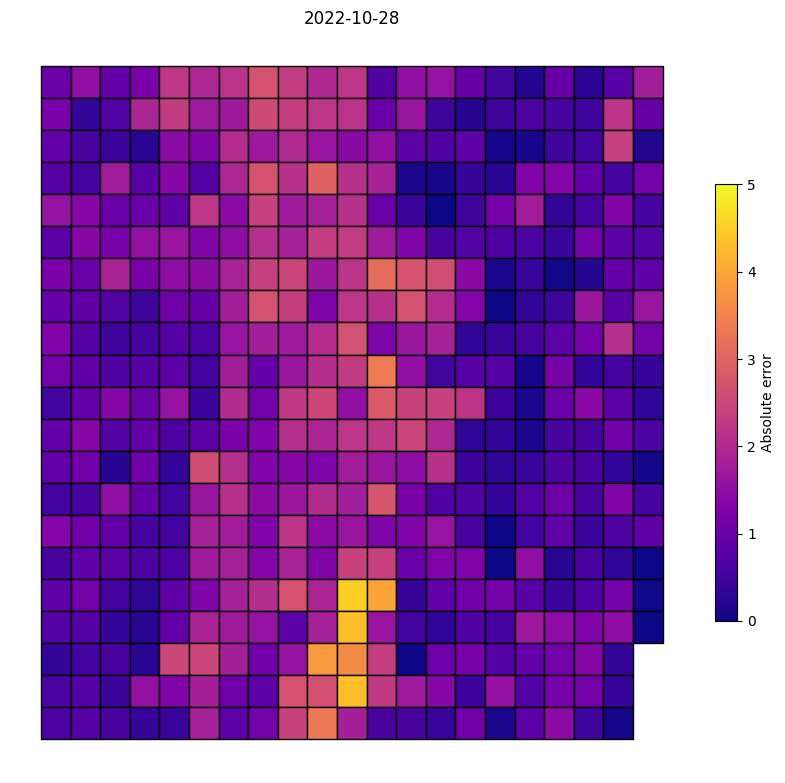

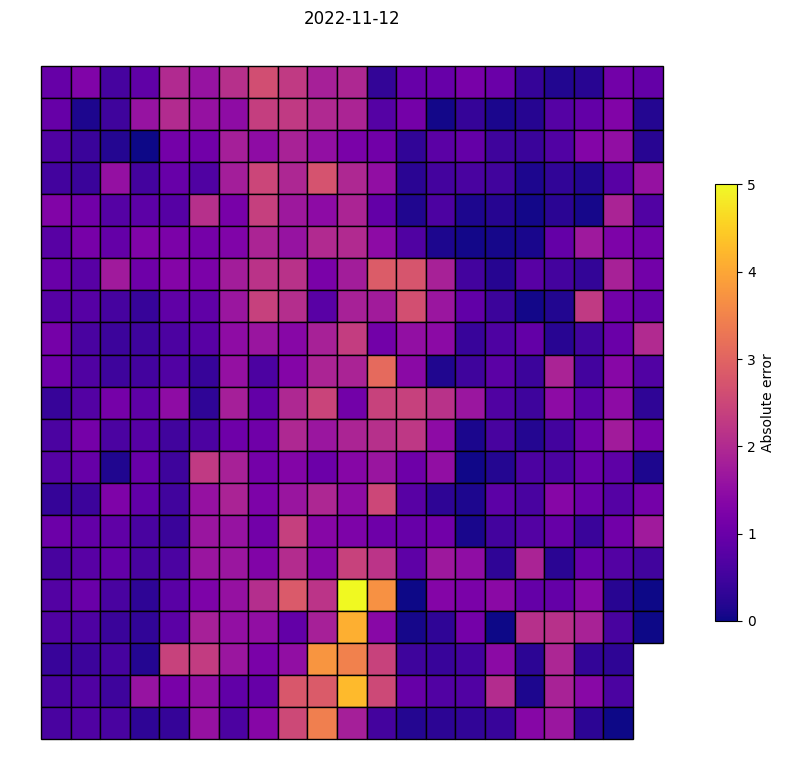

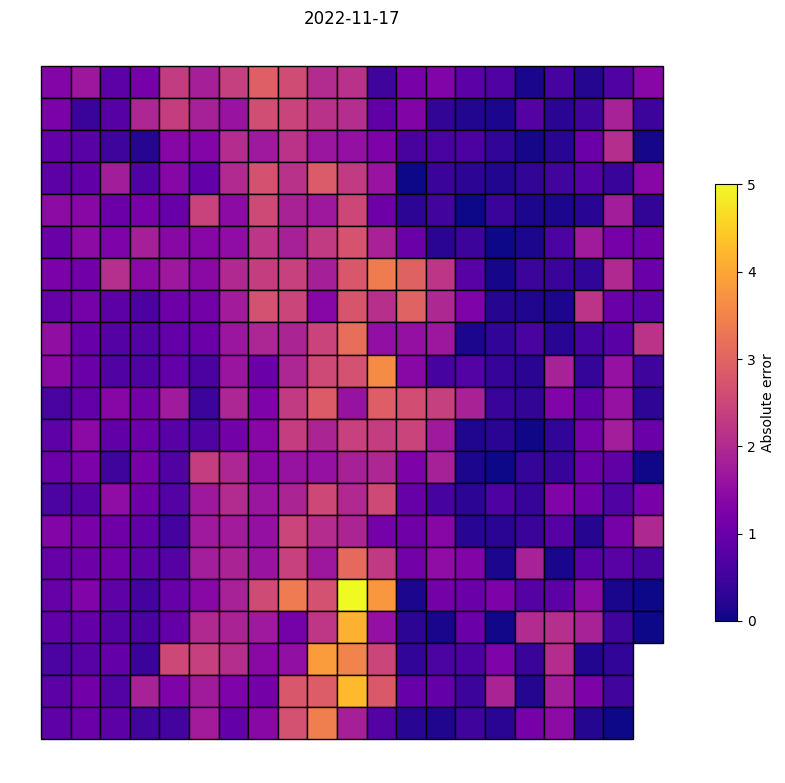

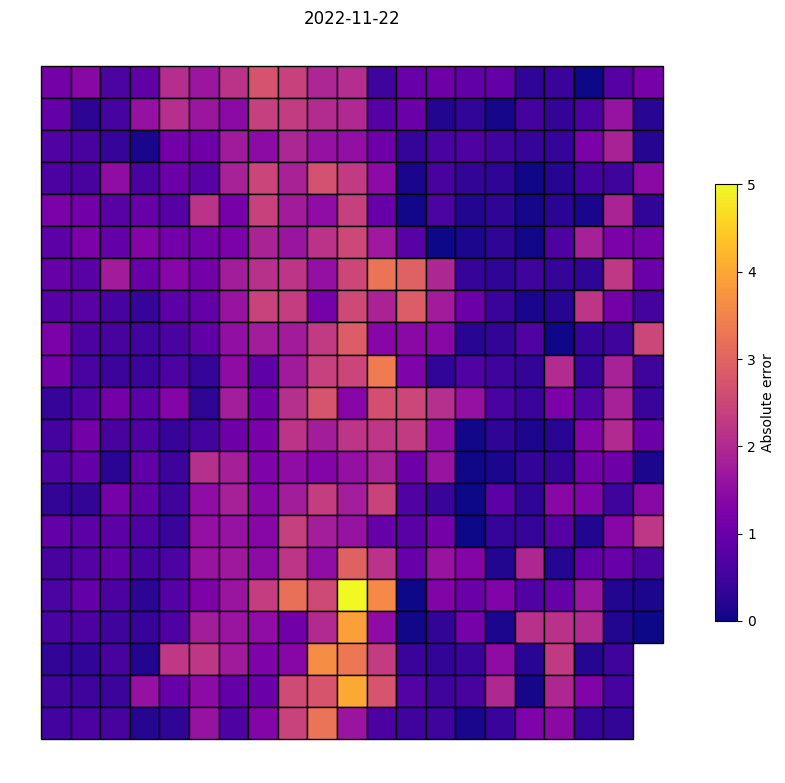

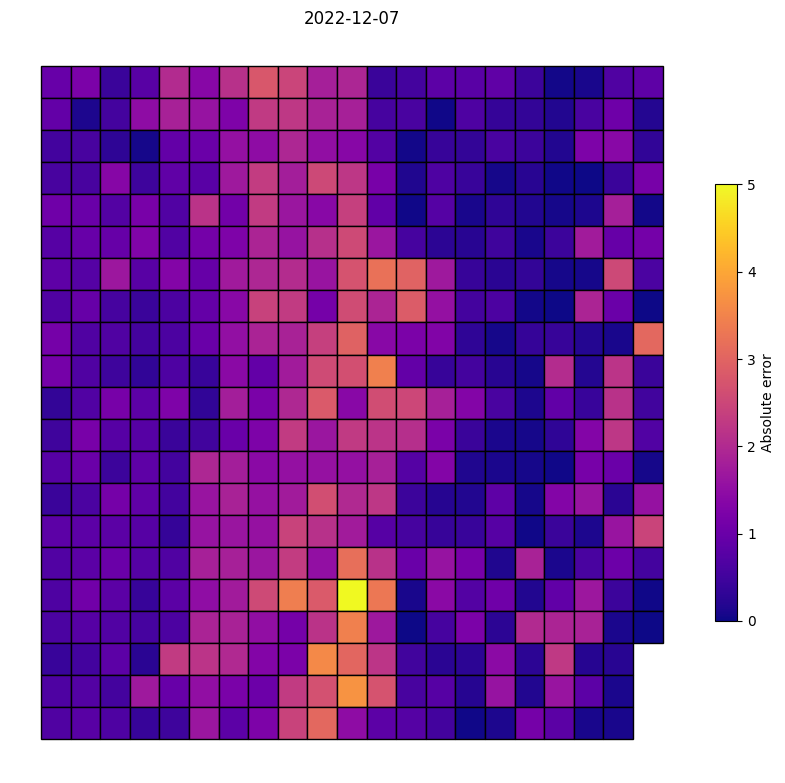

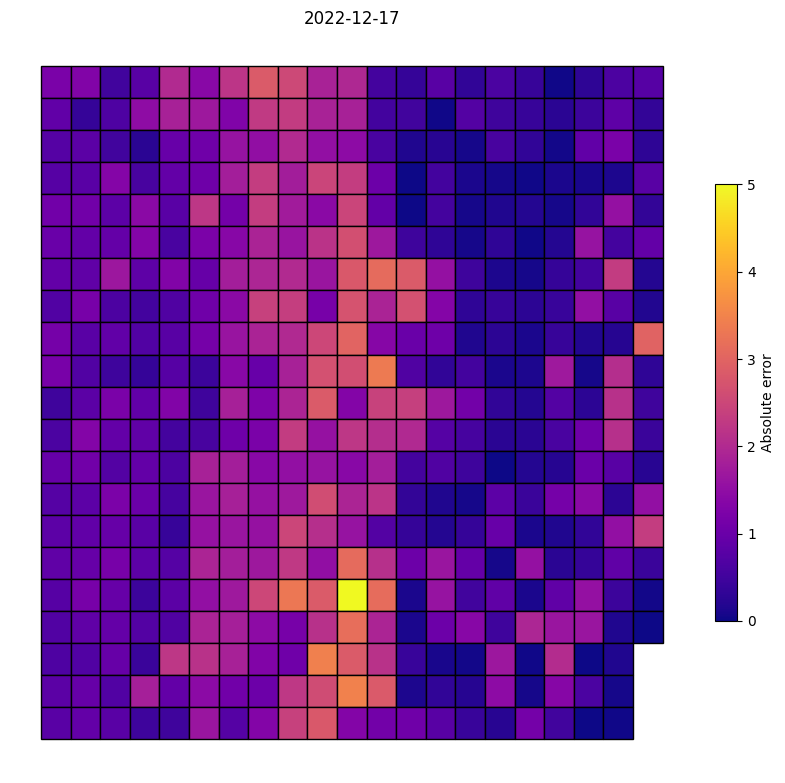

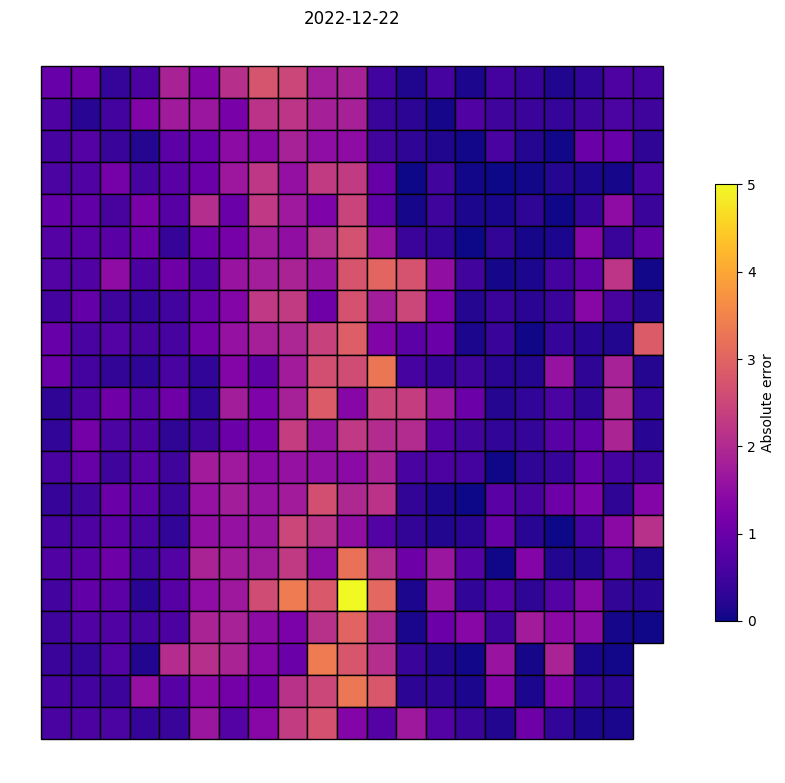

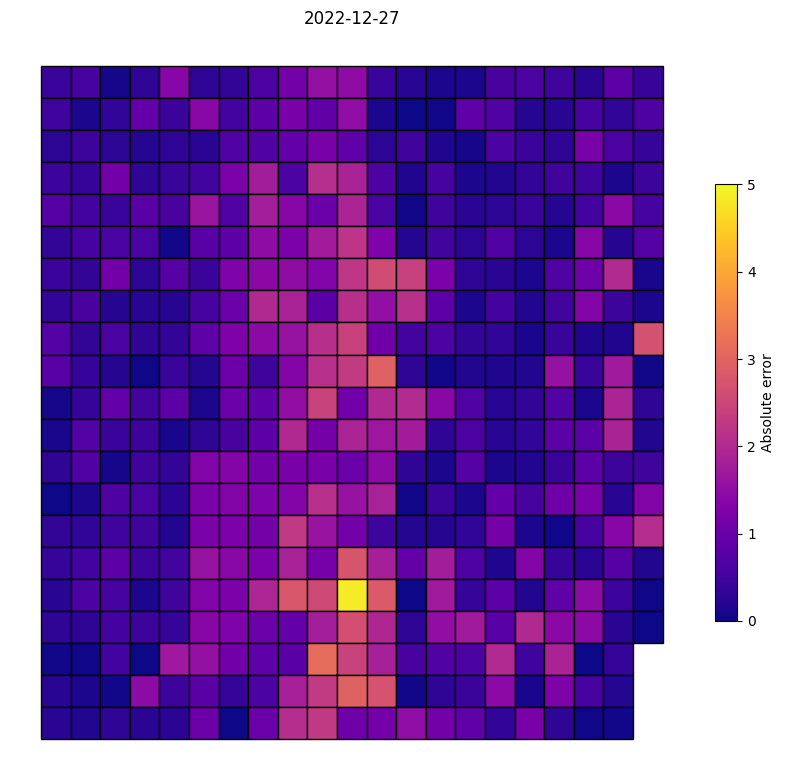

In [85]:
plt.close('all')
windows = list(box_to_embeddings_test.keys())
t_strs = box_to_t_strs_test[windows[0]]
for t_str in t_strs:
    errs_pc0 = np.array([box_to_t_str_to_pc0_err[w].get(t_str, 0) for w in windows])
    errs = errs_pc0
    # errs_pc1 = np.array([box_to_t_str_to_pc1_err[w].get(t_str, 0) for w in windows])
    # errs = errs_pc0 + errs_pc1
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), squeeze=True, constrained_layout=True)
    fig.tight_layout()
    draw_windows(ax, windows, errs, vmax=5, cmap='plasma')
    ax.set_title(t_str)
    ax.axis('off')
    ax.invert_yaxis()
    plt.show()


---

## Train on < 2023, predict on 2023

In [17]:
box_to_embeddings_train = {}
box_to_t_strs_train = {}

for t_str, d_t in embeddings_all.items():
    if t_str >= '2023-01-01':
        continue
    for w, e_w in zip(d_t['windows_pixel'], d_t['embeddings']):
        w = Box(**w)
        if w in exclude_windows:
            continue
        if w not in box_to_embeddings_train:
            box_to_embeddings_train[w] = []
        if w not in box_to_t_strs_train:
            box_to_t_strs_train[w] = []
        box_to_embeddings_train[w].append(e_w)
        box_to_t_strs_train[w].append(t_str)
    
box_to_embeddings_train = {k: np.array(v) for k, v in box_to_embeddings_train.items()}
box_to_t_strs_train = {k: np.array(v) for k, v in box_to_t_strs_train.items()}

In [18]:
box_to_embeddings_test = {}
box_to_t_strs_test = {}

for t_str, d_t in embeddings_all.items():
    if t_str < '2023-01-01' or t_str > '2023-12-31':
        continue
    for w, e_w in zip(d_t['windows_pixel'], d_t['embeddings']):
        w = Box(**w)
        if w not in box_to_embeddings_test:
            box_to_embeddings_test[w] = []
        if w not in box_to_t_strs_test:
            box_to_t_strs_test[w] = []
        box_to_embeddings_test[w].append(e_w)
        box_to_t_strs_test[w].append(t_str)

box_to_embeddings_test = {k: np.array(v) for k, v in box_to_embeddings_test.items()}
box_to_t_strs_test = {k: np.array(v) for k, v in box_to_t_strs_test.items()}

In [19]:
box_to_pca = {b: get_chip_pca(v) for b, v in tqdm(box_to_embeddings_train.items())}

  0%|          | 0/438 [00:00<?, ?it/s]

In [20]:
pc = 0
box_to_reg_pc0 = {
    b: get_chip_regressor(t_strs_to_doy(box_to_t_strs_train[b]), pca.transform(box_to_embeddings_train[b])[:, pc]) 
    for b, pca in tqdm(box_to_pca.items())
}
box_to_pc0_err = {
    b: get_chip_err(reg, t_strs_to_doy(box_to_t_strs_test[b]), box_to_pca[b].transform(box_to_embeddings_test[b])[:, pc]) 
    for b, reg in tqdm(box_to_reg_pc0.items())
}

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

In [21]:
pc = 1

box_to_reg_pc1 = {
    b: get_chip_regressor(t_strs_to_doy(box_to_t_strs_train[b]), pca.transform(box_to_embeddings_train[b])[:, pc]) 
    for b, pca in tqdm(box_to_pca.items())
}

box_to_pc1_err = {
    b: get_chip_err(reg, t_strs_to_doy(box_to_t_strs_test[b]), box_to_pca[b].transform(box_to_embeddings_test[b])[:, pc]) 
    for b, reg in tqdm(box_to_reg_pc1.items())
}

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

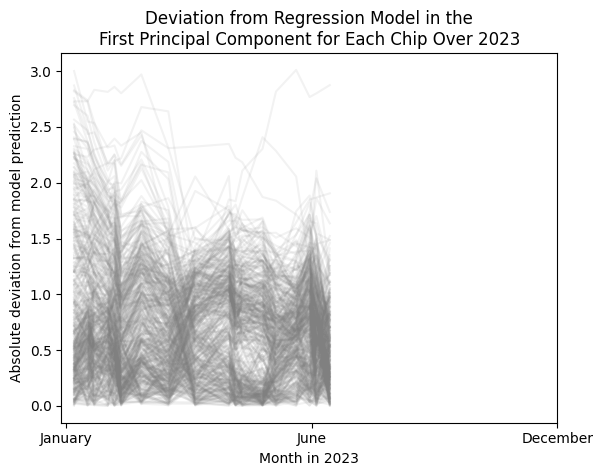

In [22]:
for b, err in box_to_pc0_err.items():
    t_doy = t_strs_to_doy(box_to_t_strs_test[b]) / 365
    plt.plot(t_doy, err, c='gray', alpha=0.1)
plt.xticks([0, 0.5, 1], ['January', 'June', 'December'])
plt.title('Deviation from Regression Model in the\nFirst Principal Component for Each Chip Over 2023')
plt.ylabel('Absolute deviation from model prediction')
plt.xlabel('Month in 2023')
plt.show()

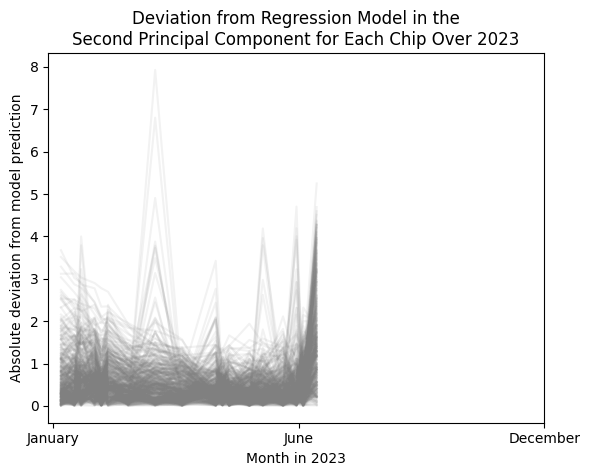

In [23]:
for b, err in box_to_pc1_err.items():
    t_doy = t_strs_to_doy(box_to_t_strs_test[b]) / 365
    plt.plot(t_doy, err, c='gray', alpha=0.1)
plt.xticks([0, 0.5, 1], ['January', 'June', 'December'])
plt.title('Deviation from Regression Model in the\nSecond Principal Component for Each Chip Over 2023')
plt.ylabel('Absolute deviation from model prediction')
plt.xlabel('Month in 2023')
plt.show()

### Intensity of change for each chip for each timestamp

As measured by the absolute difference from the regression fit.

In [28]:
box_to_t_str_to_pc0_err = {b: {t_str: e for t_str, e in zip(box_to_t_strs_test[b], v)} for b, v in box_to_pc0_err.items()}

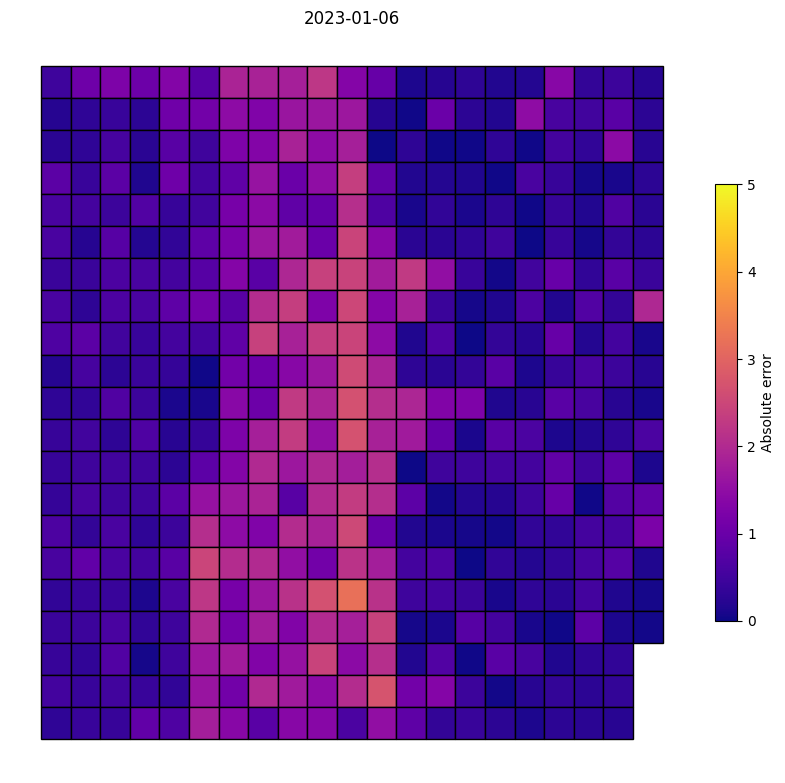

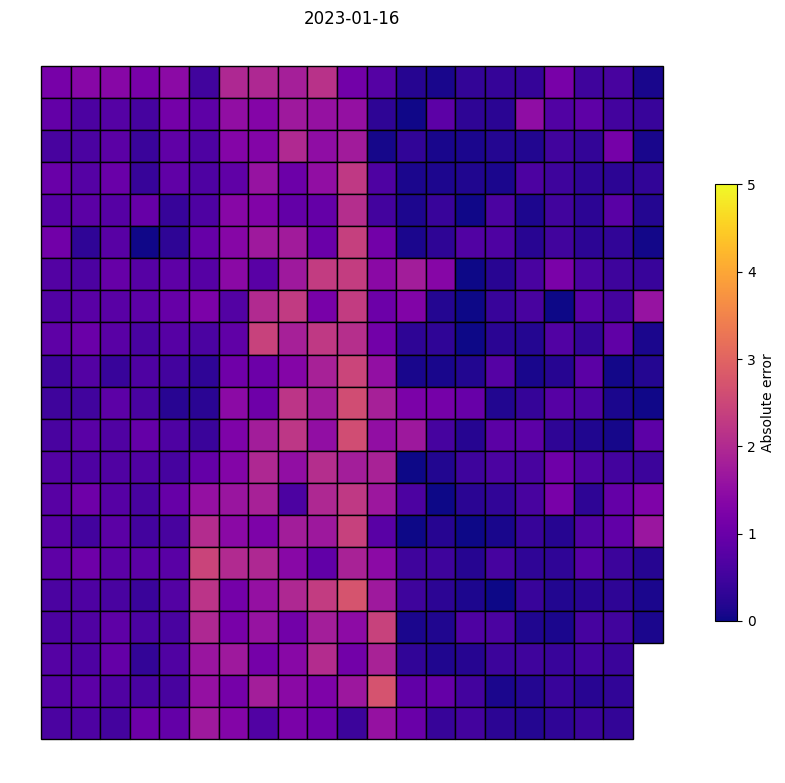

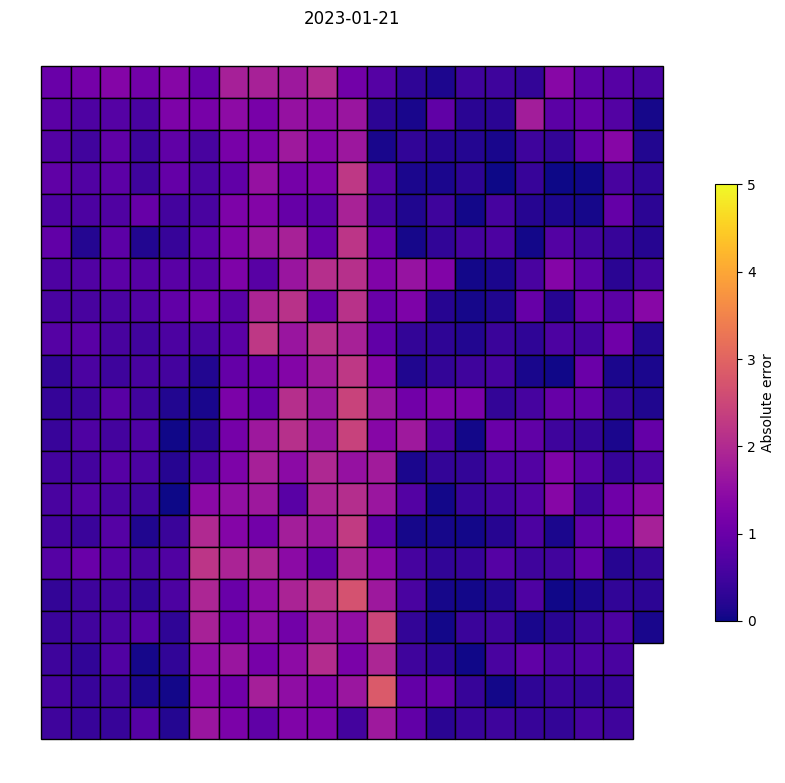

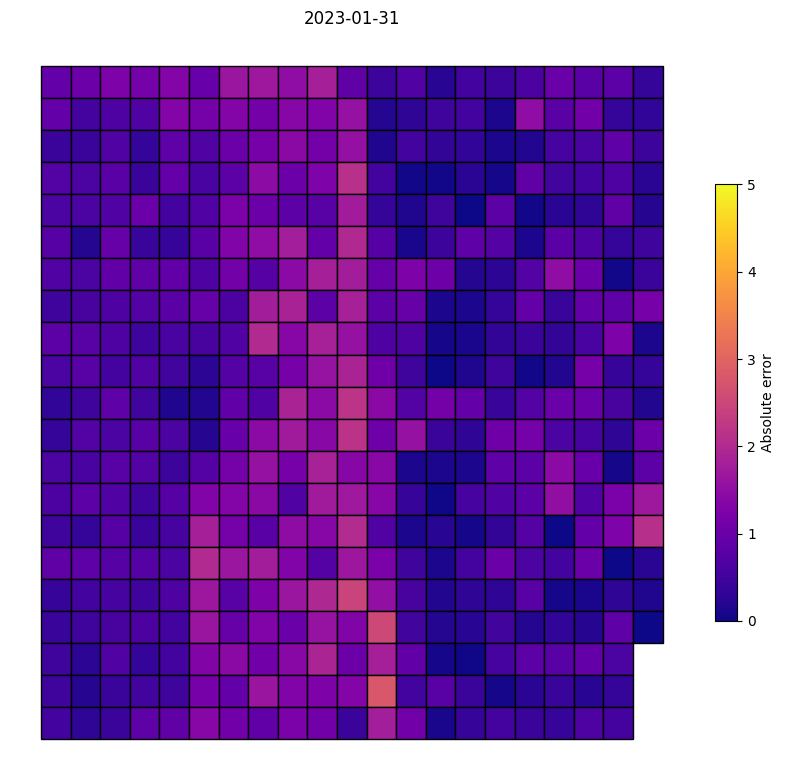

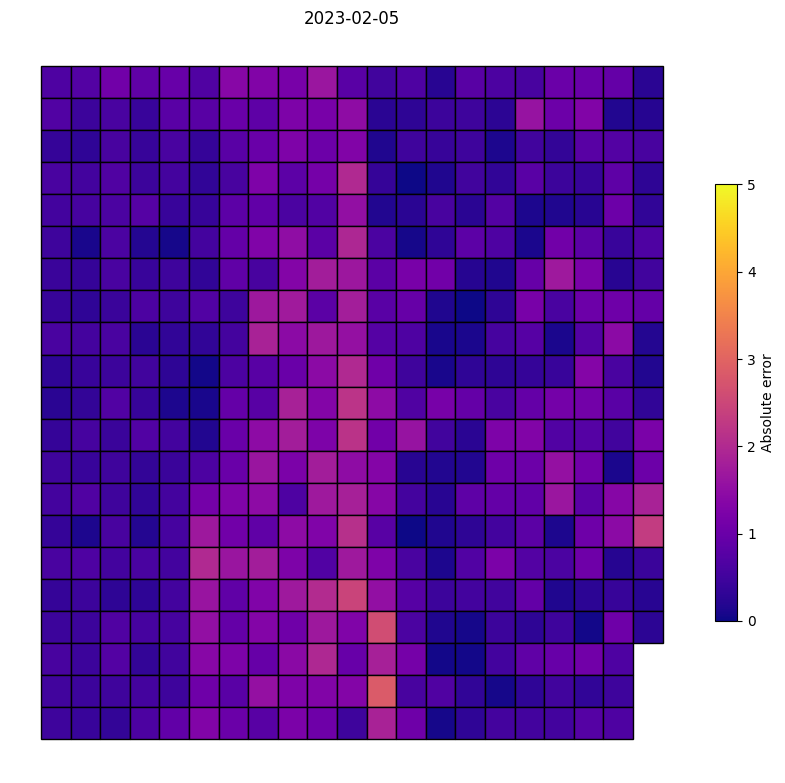

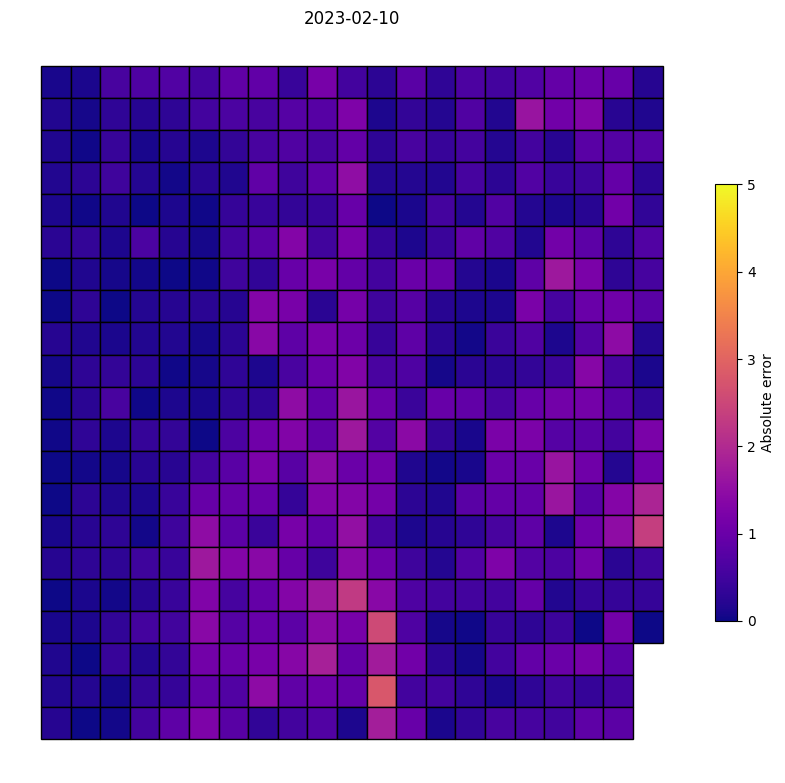

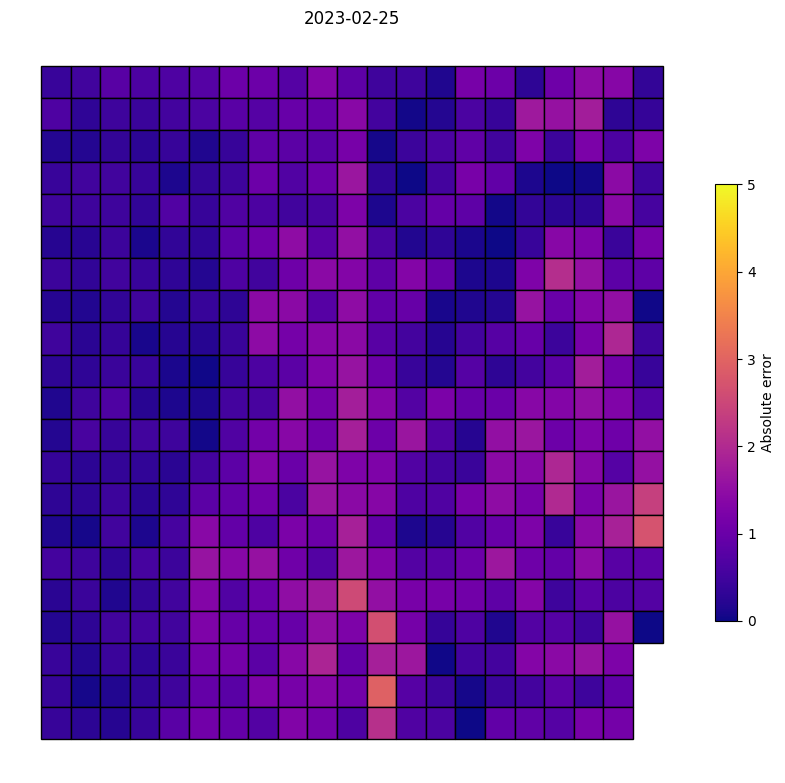

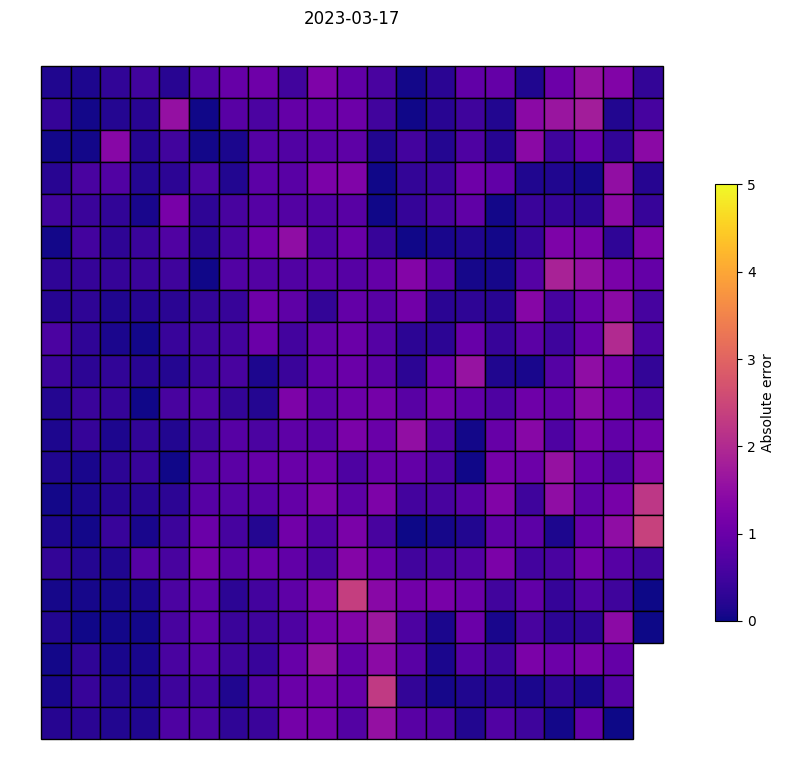

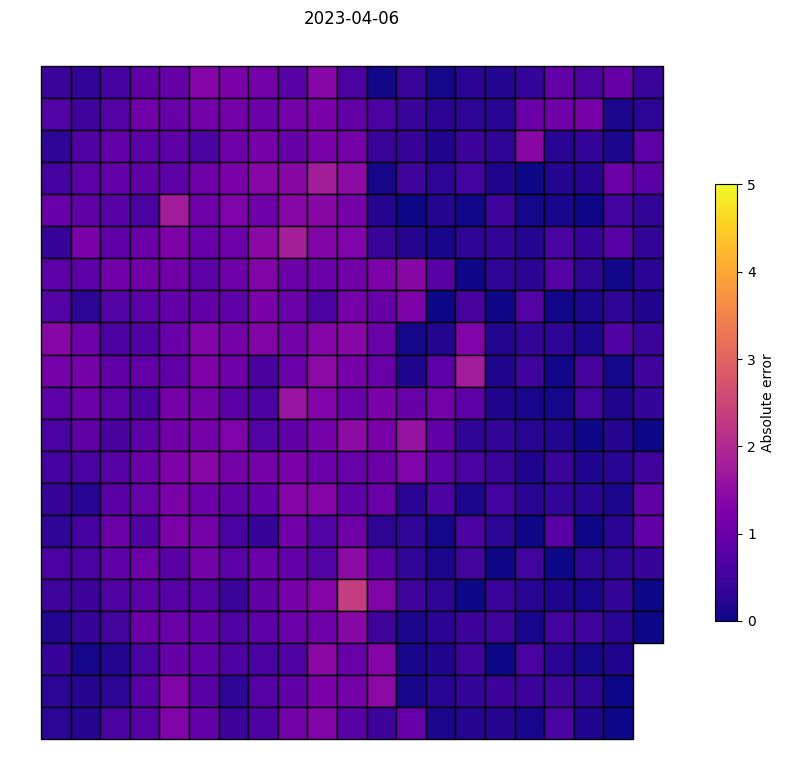

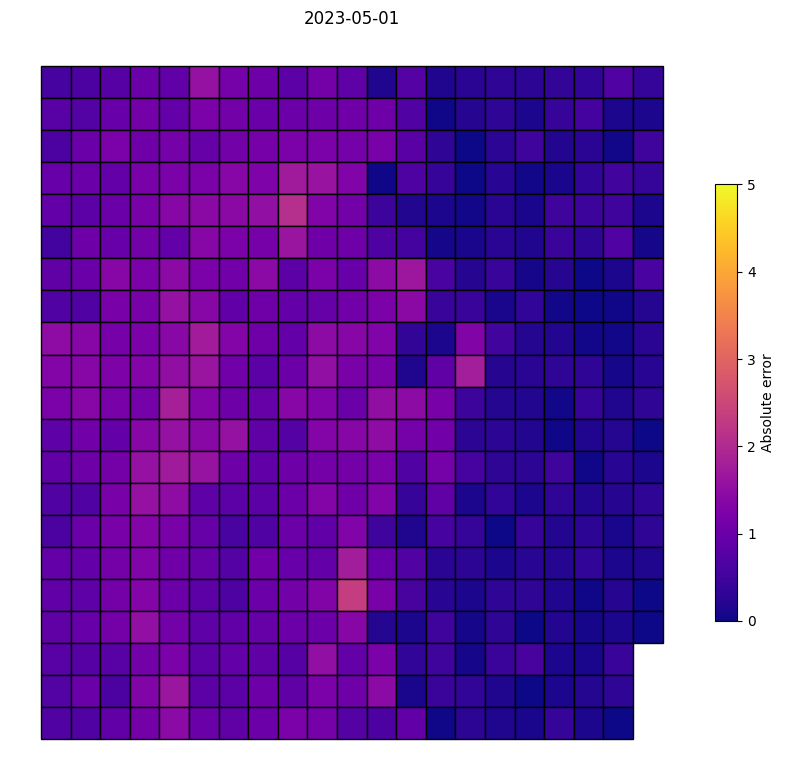

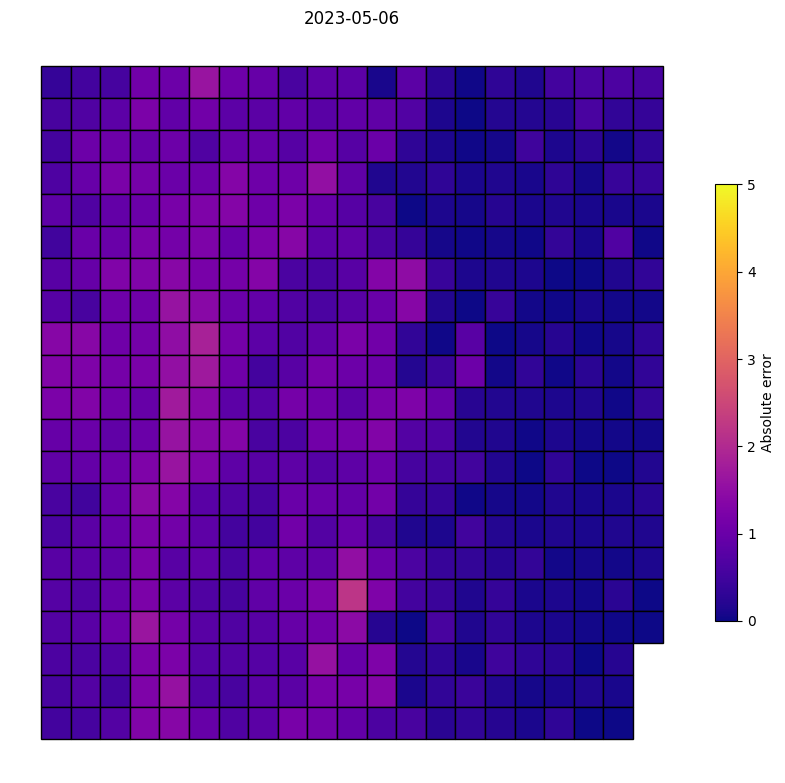

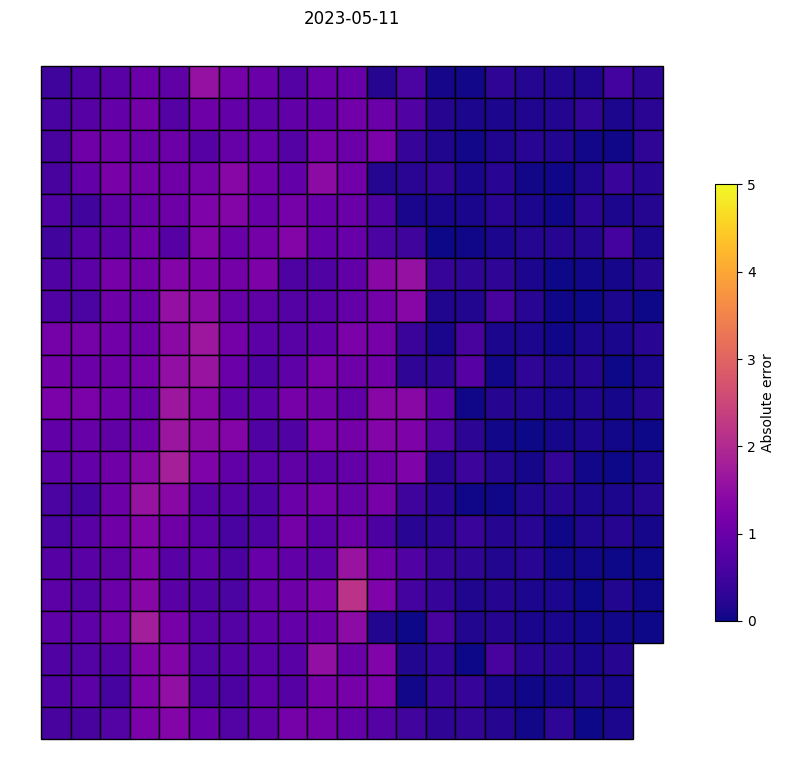

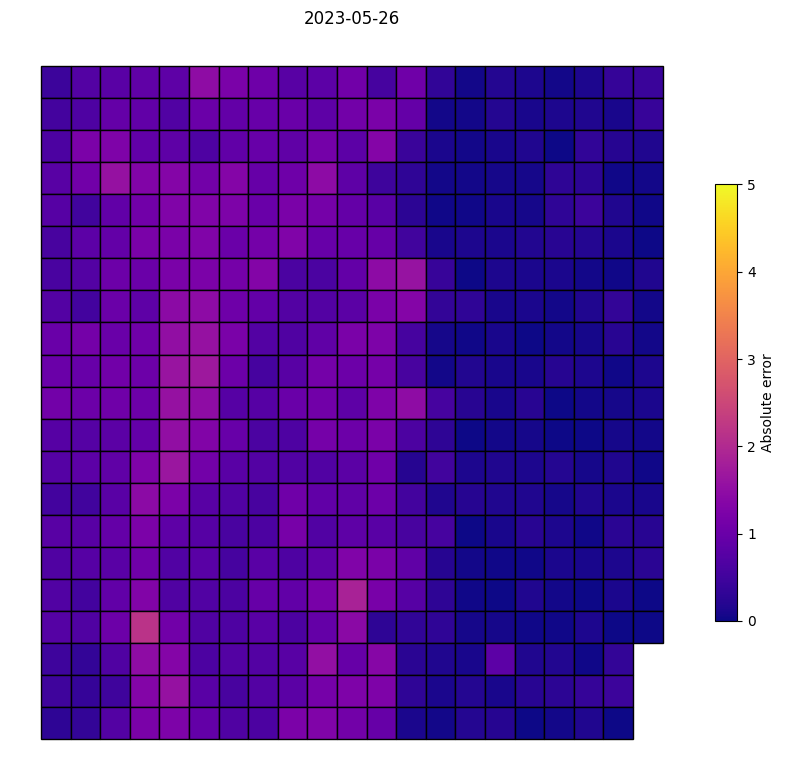

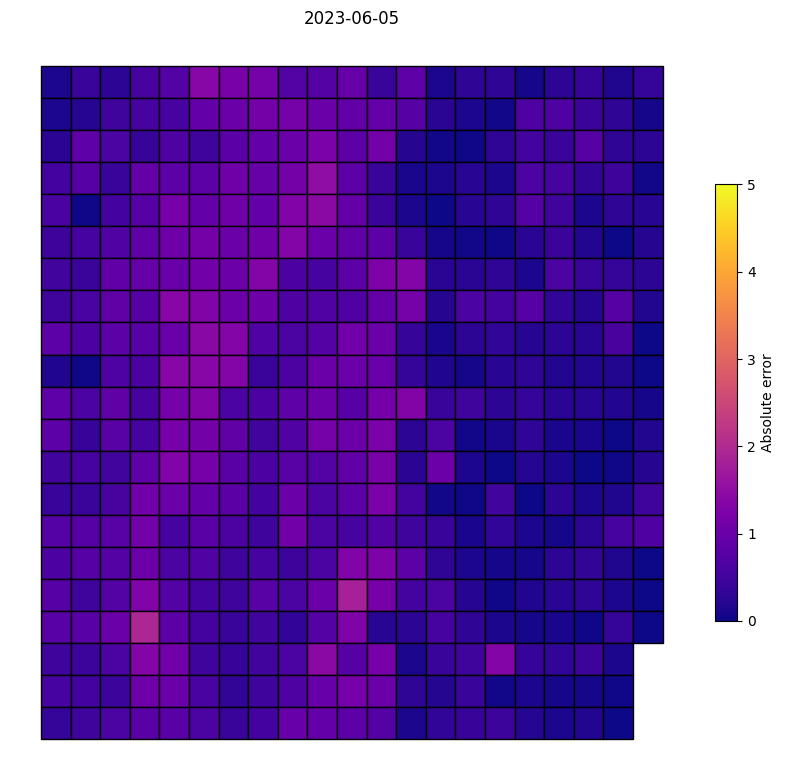

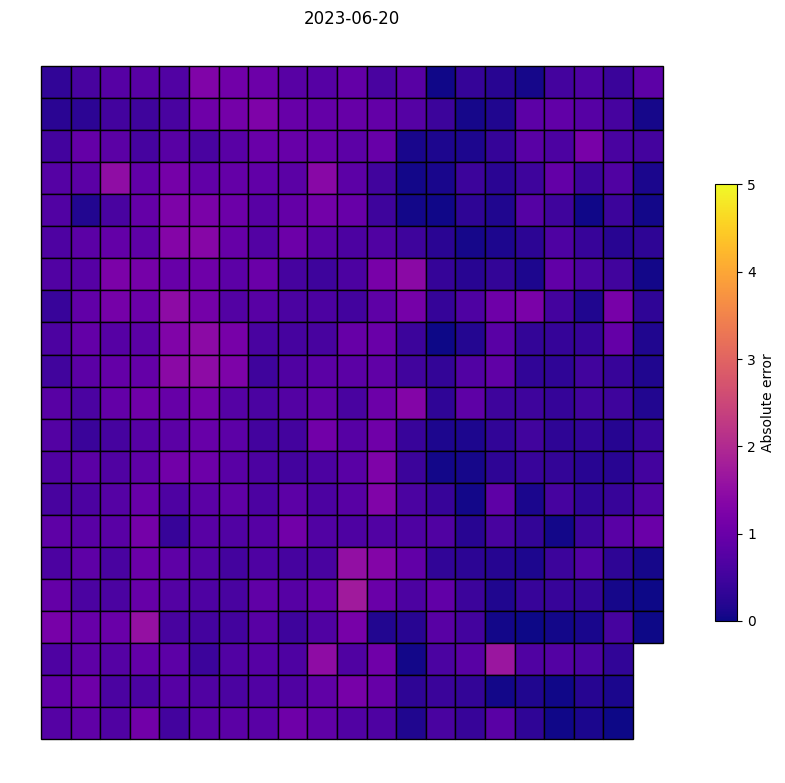

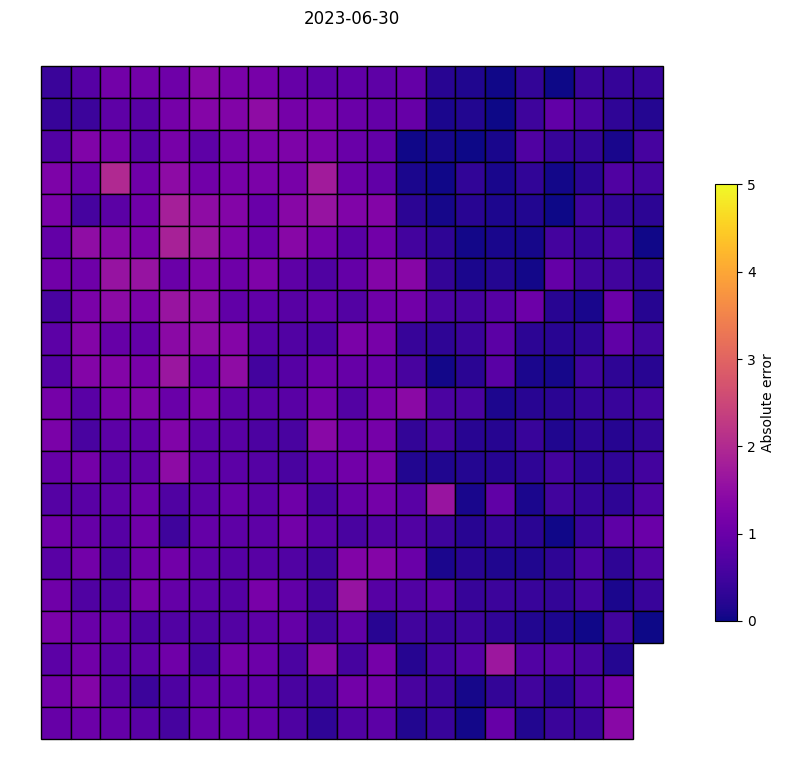

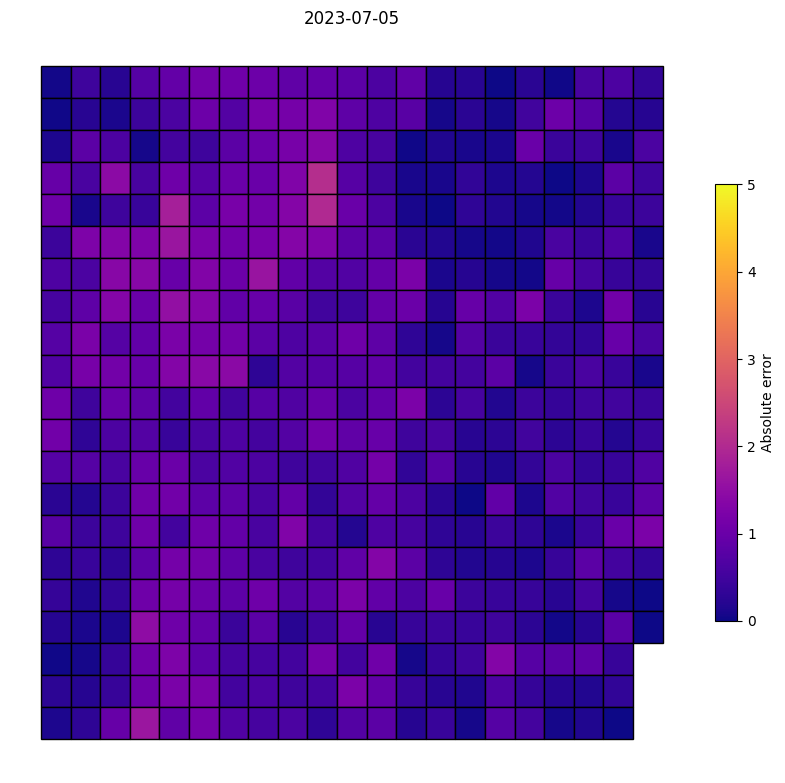

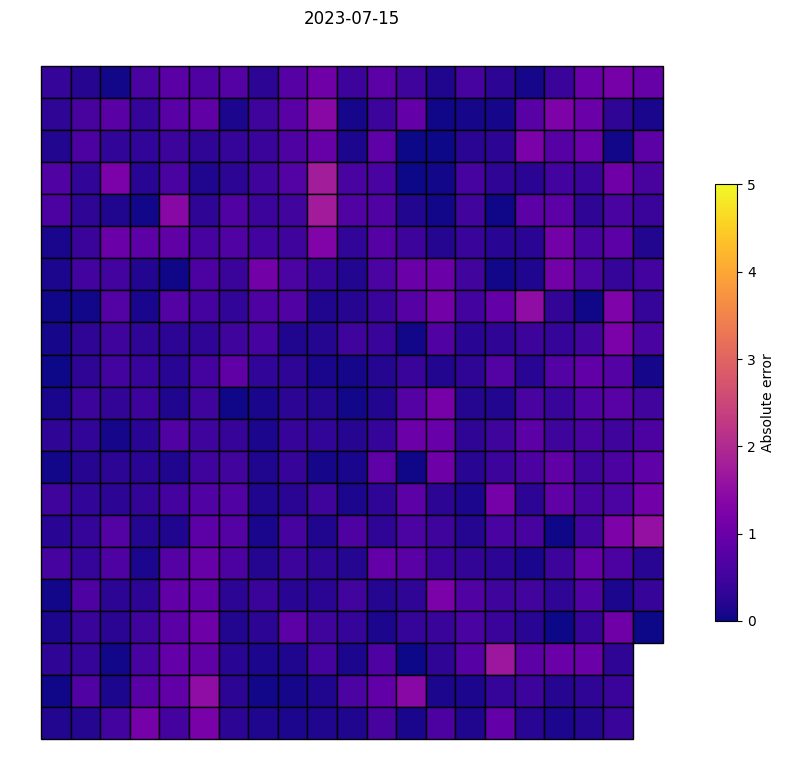

In [100]:
plt.close('all')
windows = list(box_to_embeddings_test.keys())
t_strs = box_to_t_strs_test[windows[0]]
for t_str in t_strs:
    errs_pc0 = np.array([box_to_t_str_to_pc0_err[w].get(t_str, 0) for w in windows])
    errs = errs_pc0
    # errs_pc1 = np.array([box_to_t_str_to_pc1_err[w].get(t_str, 0) for w in windows])
    # errs = errs_pc0 + errs_pc1
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), squeeze=True, constrained_layout=True)
    fig.tight_layout()
    draw_windows(ax, windows, errs, vmax=5, cmap='plasma')
    ax.set_title(t_str)
    ax.axis('off')
    ax.invert_yaxis()
    plt.show()
